<a href="https://colab.research.google.com/github/henrykosasih333-collab/weekly-assessment-ML-SESSION./blob/main/project1_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

In [ ]:
# If Auto Arima is Error, you can use this step :
!pip install optuna
!pip uninstall -y numpy scipy scikit-learn pmdarima
!pip install numpy==1.26.4 scipy==1.13.1 scikit-learn==1.4.2 pmdarima==2.0.4



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 17.0 MB/s eta 0:00:00
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.16.2
Uninstalling scipy-1.16.2:
  Successfully uninstalled scipy-1.16.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are install

# Project 1

## Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Standard Libraries ---
import math

# --- Data Handling & Visualization ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Statistics & Time Series ---
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Machine Learning & Deep Learning ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# --- Preprocessing & Evaluation ---
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Hyperparameter Optimization ---
import optuna
import pmdarima as pm

## Load Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Proyek/Data/project 1/store5.csv")
df.head()

id        date  store_nbr      family  sales  onpromotion  dcoilwtico
0  1452  2013-01-01          5  AUTOMOTIVE    0.0            0         NaN
1  1453  2013-01-01          5   BABY CARE    0.0            0         NaN
2  1454  2013-01-01          5      BEAUTY    0.0            0         NaN
3  1455  2013-01-01          5   BEVERAGES    0.0            0         NaN
4  1456  2013-01-01          5       BOOKS    0.0            0         NaN

## Initial EDA All Family

### Define Target Variable

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dcoilwtico'],
      dtype='object')

/tmp/ipython-input-1408368072.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  family_zero_ratio = df.groupby('family').apply(lambda x: (x['sales']==0).mean())


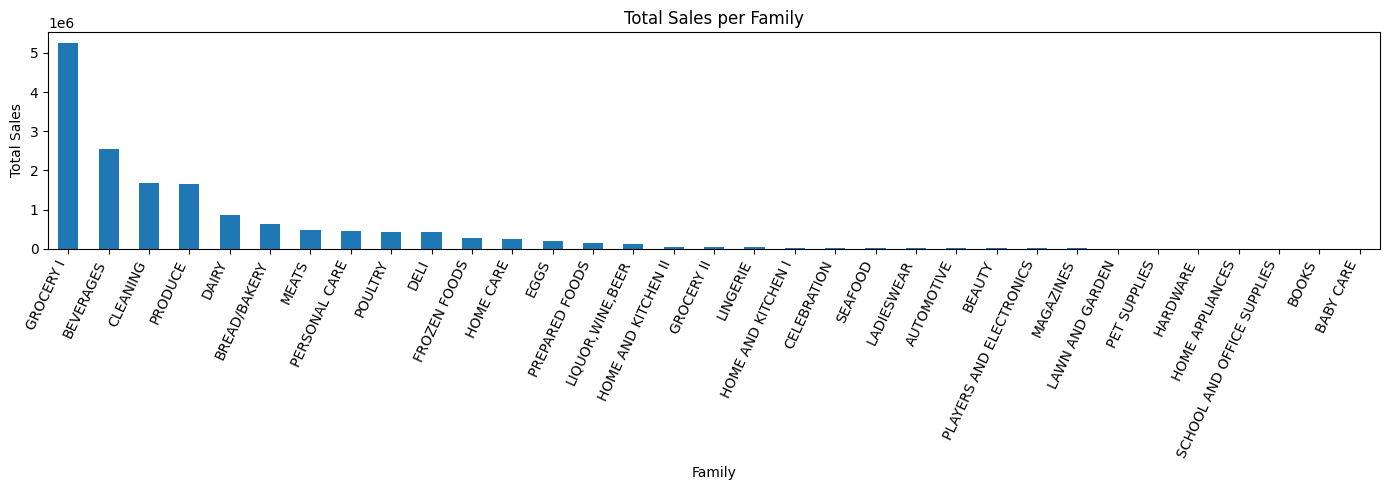

In [ ]:
family_sales = df.groupby('family')['sales'].sum().sort_values(ascending=False)
family_zero_ratio = df.groupby('family').apply(lambda x: (x['sales']==0).mean())

plt.figure(figsize=(14,5))
family_sales.plot(kind='bar')
plt.title("Total Sales per Family")
plt.xlabel("Family")
plt.ylabel("Total Sales")
plt.xticks(rotation=65, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
grocery_mean = df.loc[df['family'] == 'GROCERY I', 'sales'].mean()
other_mean = df.loc[df['family'] != 'GROCERY I', 'sales'].mean()

selisih_persen = (grocery_mean - other_mean) / other_mean * 100
print(f"Rata-rata sales GROCERY I: {grocery_mean:.2f}")
print(f"Rata-rata sales lainnya: {other_mean:.2f}")
print(f"Lebih tinggi {selisih_persen:.2f}%")


Rata-rata sales GROCERY I: 3125.11
Rata-rata sales lainnya: 191.69
Lebih tinggi 1530.30%


In [ ]:
grocery_zero_prop = (df.loc[df['family'] == 'GROCERY I', 'sales'] == 0).mean()
other_zero_prop = (df.loc[df['family'] != 'GROCERY I', 'sales'] == 0).mean()

selisih_zero_persen = (grocery_zero_prop - other_zero_prop) * 100
print(f"Proporsi 0 GROCERY I: {grocery_zero_prop:.2%}")
print(f"Proporsi 0 family lain: {other_zero_prop:.2%}")
print(f"Selisih proporsi nol: {selisih_zero_persen:.2f} poin persen")

Proporsi 0 GROCERY I: 0.30%
Proporsi 0 family lain: 23.03%
Selisih proporsi nol: -22.73 poin persen


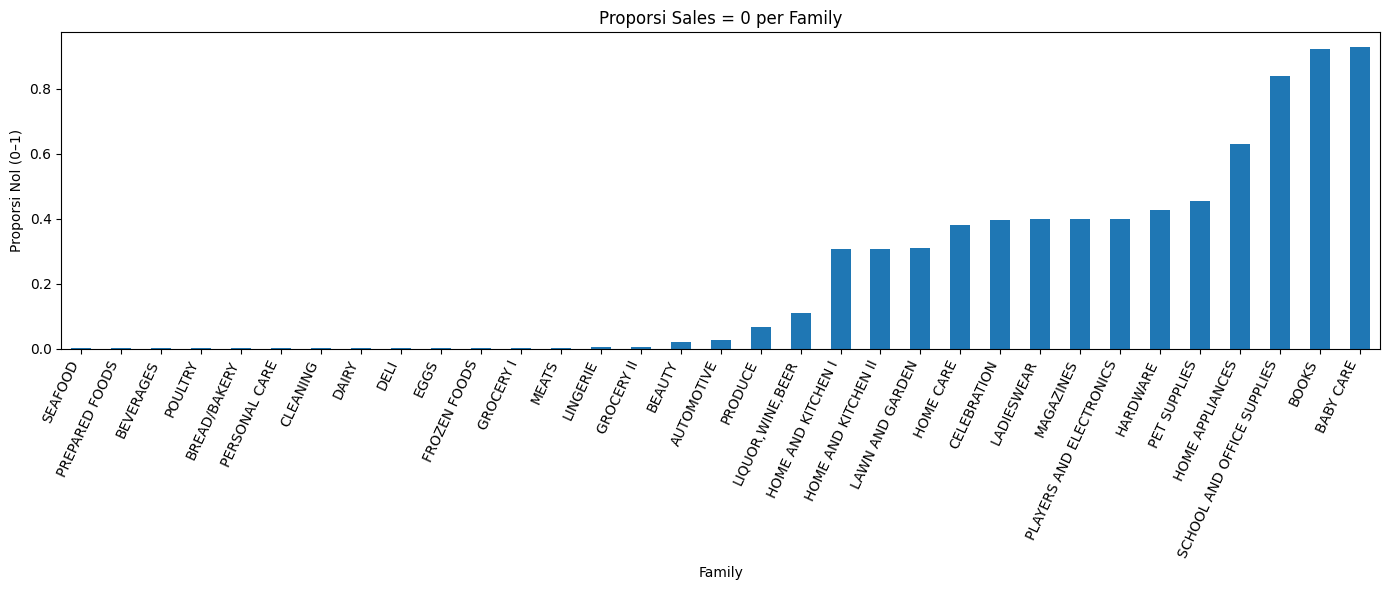

In [ ]:
plt.figure(figsize=(14,6))
family_zero_ratio.sort_values().plot(kind='bar')
plt.title("Proporsi Sales = 0 per Family")
plt.xlabel("Family")
plt.ylabel("Proporsi Nol (0–1)")
plt.xticks(rotation=65, ha='right')
plt.tight_layout()
plt.show()


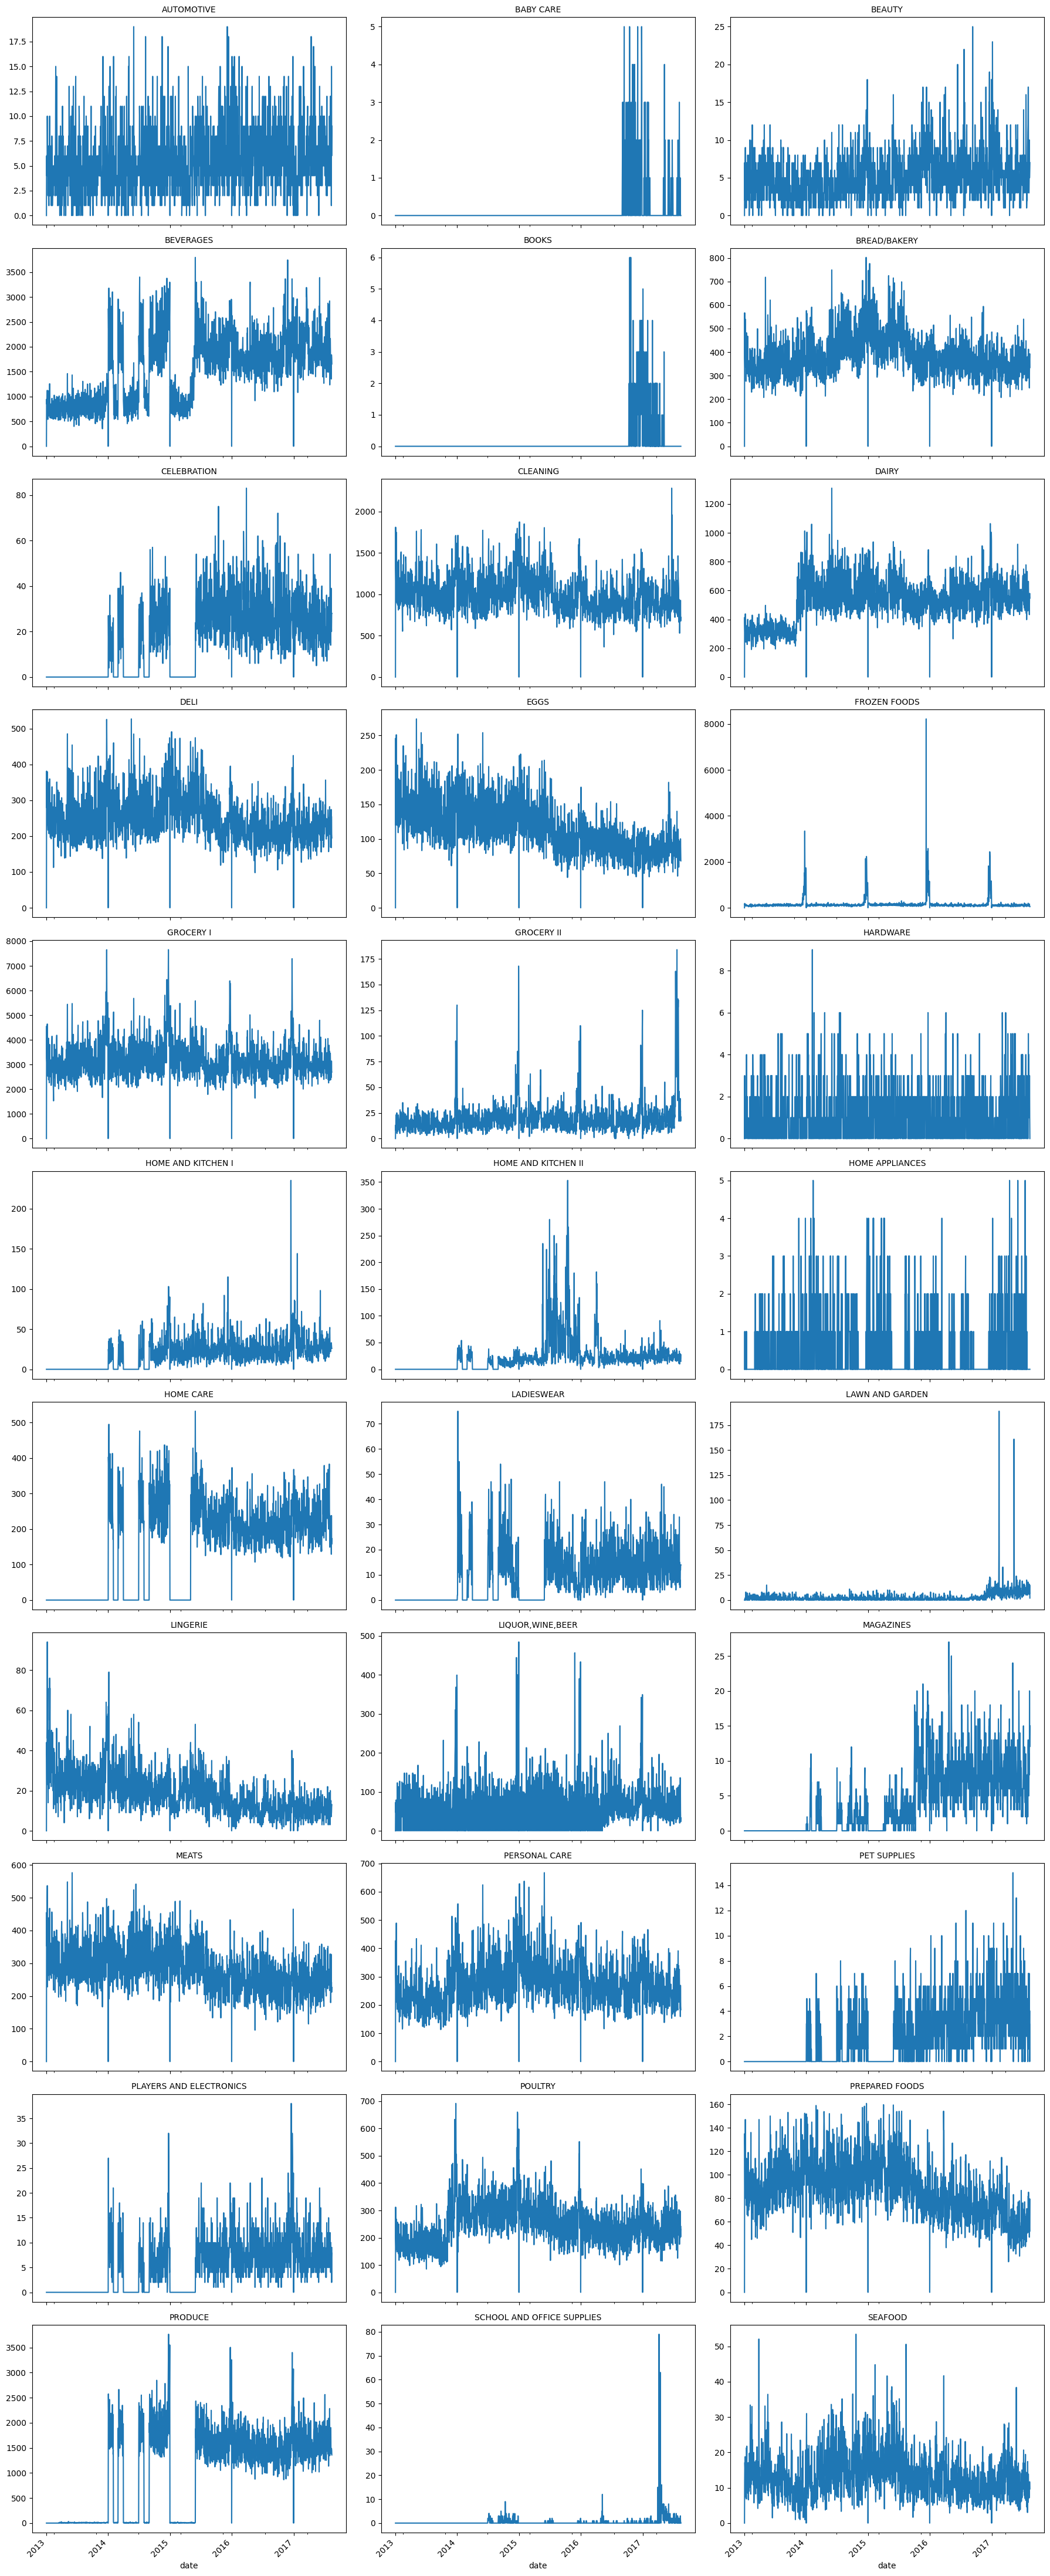

In [ ]:
families = df['family'].unique()
n = len(families)

ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows*4), sharex=True, sharey=False)

axes = axes.flatten()

for i, fam in enumerate(families):
    ax = axes[i]
    data = df[df['family'] == fam].groupby('date')['sales'].sum()
    data.plot(ax=ax)
    ax.set_title(fam, fontsize=10)
    ax.tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Insight Summary All Family

## **** Family = Grocery ****

### Intial EDA: Explore Each Variable

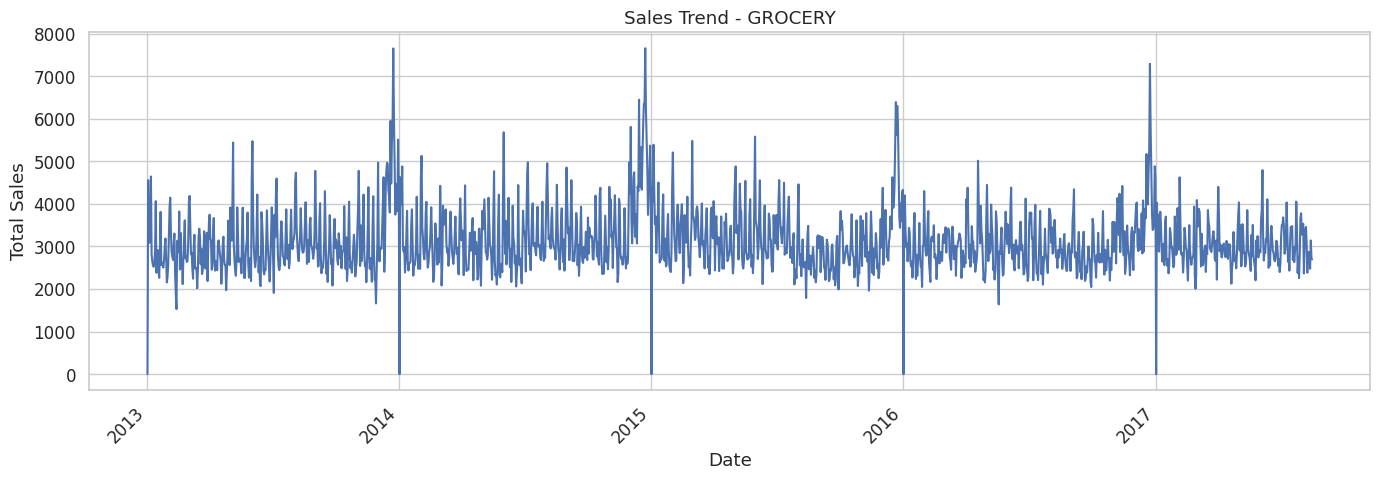

In [ ]:
# Filter hanya GROCERY
grocery = df[df['family'] == "GROCERY I"]

# Agregasi penjualan per tanggal
grocery_sales = grocery.groupby('date')['sales'].sum()

# Plot
plt.figure(figsize=(14, 5))
grocery_sales.plot()
plt.title("Sales Trend - GROCERY")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
grocery['sales'].describe()

count    1684.000000
mean     3125.107873
std       732.038714
min         0.000000
25%      2651.986000
50%      2973.500000
75%      3477.500000
max      7656.000000
Name: sales, dtype: float64

In [ ]:
print(f"Data Awal Tanggal : {grocery['date'].min()} | Data Terakhir Tanggal : {grocery['date'].max()}")

Data Awal Tanggal : 2013-01-01 00:00:00 | Data Terakhir Tanggal : 2017-08-15 00:00:00


In [ ]:
sns.set(style='whitegrid', font_scale=1.1)

# ----------------------------------------------------------
# 1️⃣ CEK KOLOM KOSONG & PERSENTASENYA
# ----------------------------------------------------------
missing_info = grocery.isnull().sum().reset_index()
missing_info.columns = ['column', 'missing_count']
missing_info['missing_percent'] = (missing_info['missing_count'] / len(grocery)) * 100
missing_info = missing_info[missing_info['missing_count'] > 0].sort_values('missing_percent', ascending=False)

print("🔍 Kolom dengan missing values:")
display(missing_info)



🔍 Kolom dengan missing values:


column  missing_count  missing_percent
6  dcoilwtico            521        30.938242


📊 Ditemukan 5 zero block pada kolom 'sales'
🔹 Panjang zero block terpanjang: 1 baris berturut-turut


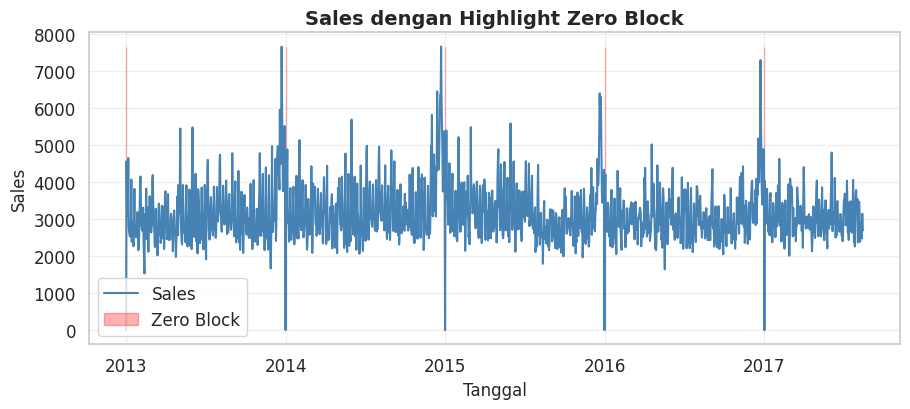

In [ ]:
# ----------------------------------------------------------
# 2️⃣ CEK ZERO BLOCK PADA KOLOM SALES
# ----------------------------------------------------------
sales = grocery['sales'].fillna(0)
zero_blocks = (sales == 0).astype(int)
group_id = (zero_blocks != zero_blocks.shift()).cumsum()

block_summary = (
    pd.DataFrame({'block_id': group_id, 'is_zero': zero_blocks})
    .groupby(['block_id', 'is_zero'])
    .size()
    .reset_index(name='block_length')
)
zero_blocks_only = block_summary[block_summary['is_zero'] == 1].reset_index(drop=True)

# pastikan copy penuh agar tidak ada warning
grocery = grocery.copy()
grocery.loc[:, 'zero_block'] = np.where(sales == 0, 1, 0)

# gunakan tanggal jika ada
x_axis = grocery['date'] if 'date' in grocery.columns else grocery.index

if not zero_blocks_only.empty:
    print(f"\n📊 Ditemukan {len(zero_blocks_only)} zero block pada kolom 'sales'")
    print(f"🔹 Panjang zero block terpanjang: {zero_blocks_only['block_length'].max()} baris berturut-turut")

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, sales, color='steelblue', linewidth=1.5, label='Sales')
    plt.fill_between(x_axis, 0, sales.max(), where=grocery['zero_block']==1,
                     color='red', alpha=0.3, label='Zero Block')
    plt.title('Sales dengan Highlight Zero Block', fontsize=14, weight='bold')
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout(pad=3)
    plt.show()
else:
    print("\n❌ Tidak ditemukan zero block pada kolom 'sales'")


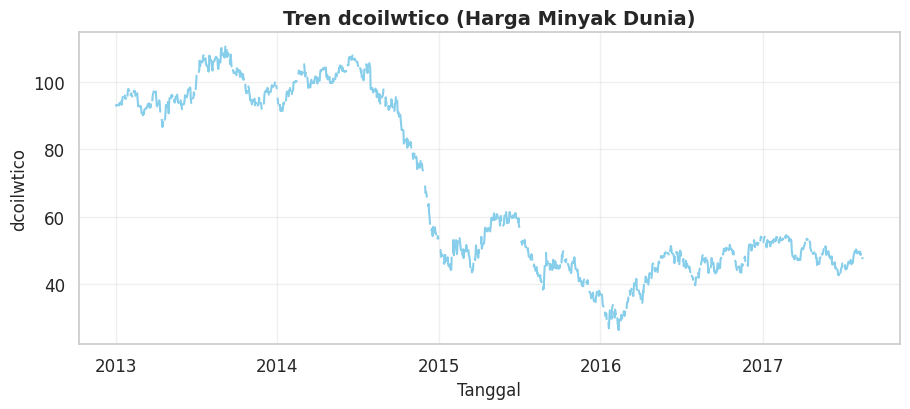

In [ ]:
# ----------------------------------------------------------
# 3️⃣ DISTRIBUSI / TREN DCOILWTICO BERDASARKAN TANGGAL
# ----------------------------------------------------------
if 'dcoilwtico' in grocery.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, grocery['dcoilwtico'], color='skyblue', linewidth=1.5)
    plt.title('Tren dcoilwtico (Harga Minyak Dunia)', fontsize=14, weight='bold')
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('dcoilwtico', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout(pad=3)
    plt.show()

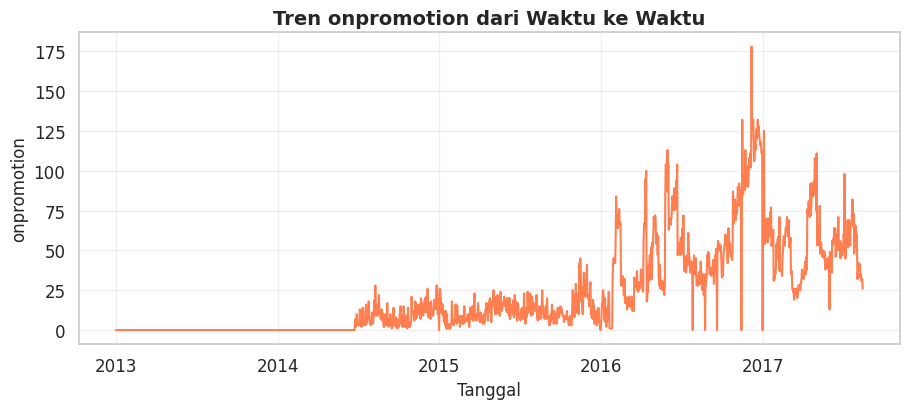

In [ ]:
# ----------------------------------------------------------
# 4️⃣ DISTRIBUSI / TREN ONPROMOTION BERDASARKAN TANGGAL
# ----------------------------------------------------------
if 'onpromotion' in grocery.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, grocery['onpromotion'], color='coral', linewidth=1.5)
    plt.title('Tren onpromotion dari Waktu ke Waktu', fontsize=14, weight='bold')
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('onpromotion', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout(pad=3)
    plt.show()

#### Initial EDA : Insight Summary Specific Family

### Data Preprocessing

### Checking Missing Value

In [ ]:
sns.set(style='whitegrid', font_scale=1.1)

# ----------------------------------------------------------
# 1️⃣ CEK KOLOM KOSONG & PERSENTASENYA
# ----------------------------------------------------------
missing_info = grocery.isnull().sum().reset_index()
missing_info.columns = ['column', 'missing_count']
missing_info['missing_percent'] = (missing_info['missing_count'] / len(grocery)) * 100
missing_info = missing_info[missing_info['missing_count'] > 0].sort_values('missing_percent', ascending=False)

# 2️⃣ Flag otomatis untuk setiap kolom yang ada missing value
for col in missing_info['column']:
    flag_col = f'is_{col}_missing'
    grocery[flag_col] = grocery[col].isna().astype(int)

# 3️⃣ Imputasi dinamis sesuai tipe data
for col in missing_info['column']:
    if np.issubdtype(grocery[col].dtype, np.number):
        grocery[col] = grocery[col].interpolate(method='linear').bfill().ffill()
    else:
        mode_val = grocery[col].mode().iloc[0] if not grocery[col].mode().empty else "UNKNOWN"
        grocery[col] = grocery[col].fillna(mode_val)

# 4️⃣ Validasi hasil
print("\n✅ Setelah flagging & imputasi:")
print("Sisa missing:", grocery.isnull().sum().sum())

# 5️⃣ (Opsional) Tampilkan total flag yang aktif
flag_cols = [c for c in grocery.columns if c.startswith('is_') and c.endswith('_missing')]
print("\n📊 Jumlah data yang awalnya missing per kolom:")
print(grocery[flag_cols].sum())

print("🔍 Kolom dengan missing values:")
display(missing_info)


✅ Setelah flagging & imputasi:
Sisa missing: 0

📊 Jumlah data yang awalnya missing per kolom:
is_dcoilwtico_missing    521
dtype: int64
🔍 Kolom dengan missing values:


column  missing_count  missing_percent
6  dcoilwtico            521        30.938242

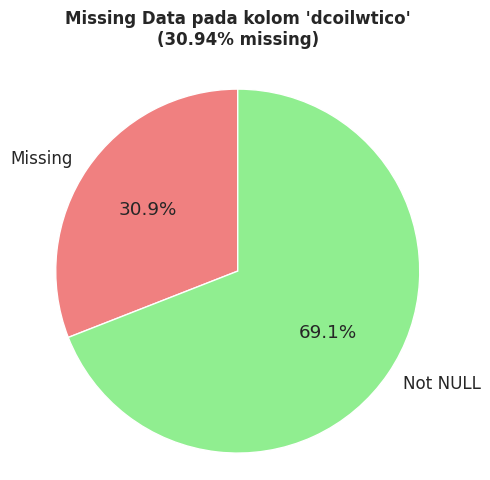

In [ ]:
for _, row in missing_info.iterrows():
    col = row['column']
    missing_count = row['missing_count']
    missing_percent = row['missing_percent']
    not_missing_count = len(grocery) - missing_count

    # Data untuk pie chart
    labels = ['Missing', 'Not NULL']
    sizes = [missing_count, not_missing_count]
    colors = ['lightcoral', 'lightgreen']

    # Plot
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(
        f"Missing Data pada kolom '{col}'\n({missing_percent:.2f}% missing)",
        loc='center', fontsize=12, fontweight='bold', pad=20
    )
    plt.axis('equal')  # menjaga bentuk pie agar bulat
    plt.tight_layout()
    plt.show()

### Handling Missing Value

In [ ]:
for col in grocery.columns:
    if grocery[col].isnull().sum() > 0:
        if np.issubdtype(grocery[col].dtype, np.number):
            # Untuk kolom numerik → interpolasi + bfill + ffill
            grocery[col] = grocery[col].interpolate(method='linear').bfill().ffill()
        else:
            # Untuk kolom non-numerik → isi dengan modus (nilai terbanyak)
            mode_val = grocery[col].mode().iloc[0] if not grocery[col].mode().empty else "UNKNOWN"
            grocery[col] = grocery[col].fillna(mode_val)

# 3️⃣ Validasi hasil
print("\n✅ Setelah handling missing values:")
print(grocery.isnull().sum()[grocery.isnull().sum() > 0])


✅ Setelah handling missing values:
Series([], dtype: int64)


### Checking Duplicate Values

In [ ]:
duplicates_all = grocery.duplicated(keep=False)

# Tampilkan hanya baris yang duplikat
grocery_duplicates_all = grocery[duplicates_all]

print(f"🔁 Jumlah baris duplikat (semua kolom): {grocery_duplicates_all.shape[0]}")
print(grocery_duplicates_all.head())

🔁 Jumlah baris duplikat (semua kolom): 0
Empty DataFrame
Columns: [id, date, store_nbr, family, sales, onpromotion, dcoilwtico, zero_block, is_dcoilwtico_missing]
Index: []


In [ ]:
duplicates_by_date = grocery[grocery.duplicated(subset=['date'], keep=False)]

print(f"🗓️ Jumlah baris duplikat berdasarkan kolom 'date': {duplicates_by_date.shape[0]}")
print(duplicates_by_date.head())

🗓️ Jumlah baris duplikat berdasarkan kolom 'date': 0
Empty DataFrame
Columns: [id, date, store_nbr, family, sales, onpromotion, dcoilwtico, zero_block, is_dcoilwtico_missing]
Index: []


### Outlier Detection

In [ ]:

print(f"Ukuran data sebelum dibersihkan (dihapus): {len(grocery)}")
threshold = 3
z_scores = np.abs(stats.zscore(grocery['sales']))
outliers = grocery[z_scores >= threshold]
outliers

Ukuran data sebelum dibersihkan (dihapus): 1684


id       date  store_nbr     family     sales  onpromotion  \
12        1464 2013-01-01          5  GROCERY I     0.000            0   
4104    222432 2013-05-05          5  GROCERY I  5441.000            0   
5028    272328 2013-06-02          5  GROCERY I  5472.000            0   
11628   628728 2013-12-19          5  GROCERY I  5949.000            0   
11694   632292 2013-12-21          5  GROCERY I  5436.000            0   
11727   634074 2013-12-22          5  GROCERY I  5898.000            0   
11760   635856 2013-12-23          5  GROCERY I  7652.000            0   
11793   637638 2013-12-24          5  GROCERY I  6057.000            0   
11958   646548 2013-12-30          5  GROCERY I  5508.000            0   
12024   650112 2014-01-01          5  GROCERY I     0.000            0   
17007   919194 2014-06-01          5  GROCERY I  5682.000            0   
23079  1247082 2014-12-02          5  GROCERY I  5809.000           11   
23475  1268466 2014-12-14          5  GROCERY I  6446.000           18   
23574  1273812 2014-12-17          5  GROCERY I  5328.000           10   
23673  1279158 2014-12-20          5  GROCERY I  5857.000           14   
23706  1280940 2014-12-21          5  GROCERY I  6351.000           19   
23739  1282722 2014-12-22          5  GROCERY I  6355.000           15   
23772  1284504 2014-12-23          5  GROCERY I  7656.000           14   
23805  1286286 2014-12-24          5  GROCERY I  6221.000           13   
23970  1295196 2014-12-30          5  GROCERY I  5367.000           12   
24036  1298760 2015-01-01          5  GROCERY I     0.000            0   
24135  1304106 2015-01-04          5  GROCERY I  5390.000           23   
25983  1403898 2015-03-01          5  GROCERY I  5479.000            5   
28986  1566060 2015-05-31          5  GROCERY I  5580.000           17   
35685  1927806 2015-12-20          5  GROCERY I  5356.480            9   
35718  1929588 2015-12-21          5  GROCERY I  6390.371           10   
35751  1931370 2015-12-22          5  GROCERY I  5621.233           12   
35784  1933152 2015-12-23          5  GROCERY I  6300.272            3   
35817  1934934 2015-12-24          5  GROCERY I  5894.698            8   
36048  1947408 2016-01-01          5  GROCERY I     0.000            0   
47829  2583582 2016-12-23          5  GROCERY I  7289.000          128   
47862  2585364 2016-12-24          5  GROCERY I  5829.000          123   
48093  2597838 2017-01-01          5  GROCERY I     0.000            0   

       dcoilwtico  zero_block  is_dcoilwtico_missing  
12      93.140000           1                      1  
4104    95.616667           0                      1  
5028    92.916667           0                      1  
11628   98.400000           0                      0  
11694   98.946667           0                      1  
11727   98.783333           0                      1  
11760   98.620000           0                      0  
11793   98.870000           0                      0  
11958   98.900000           0                      0  
12024   96.655000           1                      1  
17007  103.180000           0                      1  
23079   66.990000           0                      0  
23475   56.576667           0                      1  
23574   56.430000           0                      0  
23673   56.356667           0                      1  
23706   55.803333           0                      1  
23739   55.250000           0                      0  
23772   56.780000           0                      0  
23805   55.700000           0                      0  
23970   54.140000           0                      0  
24036   53.085000           1                      1  
24135   50.940000           0                      1  
25983   49.673333           0                      1  
28986   60.243333           0                      1  
35685   34.606667           0                      1  
35718   34.550000           0                      0  
35751   36

### Handling Outlier (if necessary)

In [ ]:
# grocery = grocery[z_scores < threshold]
# print(f"Jumlah data akhir     : {len(grocery)}")

### Feature Engineering / New Features

#### Basic Feature Engineering

In [ ]:
grocery_basic=grocery.copy()

In [ ]:
# ==== 1️⃣ Fitur dasar dari tanggal ====
grocery_basic['year'] = grocery_basic['date'].dt.year
grocery_basic['month'] = grocery_basic['date'].dt.month
grocery_basic['day'] = grocery_basic['date'].dt.day
grocery_basic['dayofweek'] = grocery_basic['date'].dt.dayofweek   # 0=Senin, 6=Minggu
grocery_basic['weekofyear'] = grocery_basic['date'].dt.isocalendar().week.astype(int)
grocery_basic['is_weekend'] = grocery_basic['dayofweek'].isin([5, 6]).astype(int)

# ==== 2️⃣ Fitur status promosi ====
grocery_basic['is_onpromotion'] = (grocery_basic['onpromotion'] > 0).astype(int)

# ==== 3️⃣ Fitur terkait penjualan ====
grocery_basic['is_zero_sales'] = (grocery_basic['sales'] == 0).astype(int)

##### Advance EDA Basic Feature Engineering

In [ ]:
cols_focus = [
    'year', 'month', 'day', 'dayofweek', 'weekofyear',
    'is_weekend', 'is_onpromotion', 'is_zero_sales'
]

In [ ]:
print(" INFORMASI DASAR DATAFRAME")
grocery_basic[cols_focus].info()

print("\n DESKRIPSI STATISTIK")
grocery_basic[cols_focus].describe(include='all').T

 INFORMASI DASAR DATAFRAME
<class 'pandas.core.frame.DataFrame'>
Index: 1684 entries, 12 to 55551
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   year            1684 non-null   int32
 1   month           1684 non-null   int32
 2   day             1684 non-null   int32
 3   dayofweek       1684 non-null   int32
 4   weekofyear      1684 non-null   int64
 5   is_weekend      1684 non-null   int64
 6   is_onpromotion  1684 non-null   int64
 7   is_zero_sales   1684 non-null   int64
dtypes: int32(4), int64(4)
memory usage: 92.1 KB

 DESKRIPSI STATISTIK


count         mean        std     min     25%     50%  \
year            1684.0  2014.837886   1.345917  2013.0  2014.0  2015.0   
month           1684.0     6.207838   3.386673     1.0     3.0     6.0   
day             1684.0    15.630048   8.797400     1.0     8.0    16.0   
dayofweek       1684.0     2.997031   2.001334     0.0     1.0     3.0   
weekofyear      1684.0    25.242874  14.799063     1.0    13.0    25.0   
is_weekend      1684.0     0.285629   0.451848     0.0     0.0     0.0   
is_onpromotion  1684.0     0.675772   0.468225     0.0     0.0     1.0   
is_zero_sales   1684.0     0.002969   0.054425     0.0     0.0     0.0   

                   75%     max  
year            2016.0  2017.0  
month              9.0    12.0  
day               23.0    31.0  
dayofweek          5.0     6.0  
weekofyear        38.0    53.0  
is_weekend         1.0     1.0  
is_onpromotion     1.0     1.0  
is_zero_sales      0.0     1.0

In [ ]:
print("JUMLAH NILAI UNIK PER KOLOM:")
for col in cols_focus:
    print(f"{col}: {grocery_basic[col].nunique()} unique values")


JUMLAH NILAI UNIK PER KOLOM:
year: 5 unique values
month: 12 unique values
day: 31 unique values
dayofweek: 7 unique values
weekofyear: 53 unique values
is_weekend: 2 unique values
is_onpromotion: 2 unique values
is_zero_sales: 2 unique values


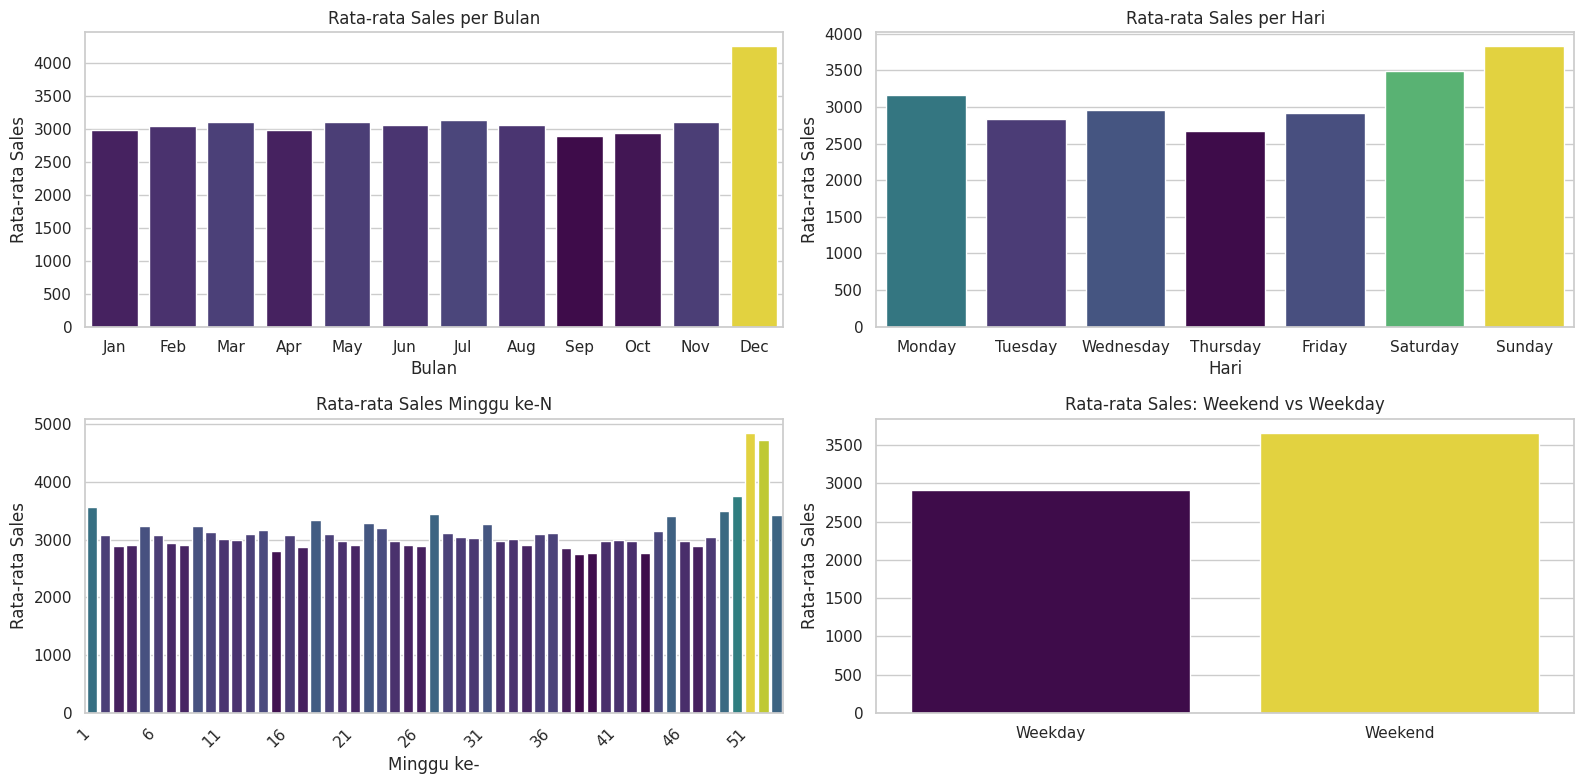

In [ ]:
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.set_theme(style="whitegrid")
cmap = sns.color_palette("viridis", as_cmap=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# --- Plot 1: Rata-rata Sales per Bulan ---
month_mean = grocery_basic.groupby('month')['sales'].mean().reindex(range(1,13))
colors = list(cmap((month_mean - month_mean.min()) / (month_mean.max() - month_mean.min())))
sns.barplot(
    x=[month_mapping[m] for m in month_mean.index],
    y=month_mean.values,
    hue=[month_mapping[m] for m in month_mean.index],
    palette=colors,
    legend=False,
    ax=axes[0,0]
)
axes[0,0].set_title('Rata-rata Sales per Bulan')
axes[0,0].set_xlabel('Bulan')
axes[0,0].set_ylabel('Rata-rata Sales')

# --- Plot 2: Rata-rata Sales per Hari ---
day_mean = grocery_basic.groupby('dayofweek')['sales'].mean().reindex(range(7))
colors = list(cmap((day_mean - day_mean.min()) / (day_mean.max() - day_mean.min())))
sns.barplot(
    x=[day_mapping[d] for d in day_mean.index],
    y=day_mean.values,
    hue=[day_mapping[d] for d in day_mean.index],
    palette=colors,
    legend=False,
    ax=axes[0,1]
)
axes[0,1].set_title('Rata-rata Sales per Hari')
axes[0,1].set_xlabel('Hari')
axes[0,1].set_ylabel('Rata-rata Sales')

# --- Plot 3: Rata-rata Sales per Minggu ke-N ---
week_mean = grocery_basic.groupby('weekofyear')['sales'].mean()
colors = list(cmap((week_mean - week_mean.min()) / (week_mean.max() - week_mean.min())))
sns.barplot(
    x=week_mean.index,
    y=week_mean.values,
    hue=week_mean.index,
    palette=colors,
    legend=False,
    ax=axes[1,0]
)
axes[1,0].set_title('Rata-rata Sales Minggu ke-N')
axes[1,0].set_xlabel('Minggu ke-')
axes[1,0].set_ylabel('Rata-rata Sales')

interval = 5
all_ticks = axes[1,0].get_xticks()
selected_ticks = all_ticks[::interval]
selected_labels = np.arange(1, len(all_ticks) + 1, interval)
axes[1,0].set_xticks(selected_ticks)
axes[1,0].set_xticklabels(selected_labels, rotation=45, ha='right')

# --- Plot 4: Perbandingan Sales Weekend vs Weekday ---
weekend_mean = grocery_basic.groupby('is_weekend')['sales'].mean().reindex([0,1])
colors = list(cmap((weekend_mean - weekend_mean.min()) / (weekend_mean.max() - weekend_mean.min())))
sns.barplot(
    x=['Weekday', 'Weekend'],
    y=weekend_mean.values,
    hue=['Weekday', 'Weekend'],
    palette=colors,
    legend=False,
    ax=axes[1,1]
)
axes[1,1].set_title('Rata-rata Sales: Weekend vs Weekday')
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Rata-rata Sales')

plt.tight_layout()
plt.show()

#### Advance Feature Engineering

In [ ]:
grocery_basic.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dcoilwtico', 'zero_block', 'is_dcoilwtico_missing', 'year', 'month',
       'day', 'dayofweek', 'weekofyear', 'is_weekend', 'is_onpromotion',
       'is_zero_sales'],
      dtype='object')

In [ ]:
grocery_adv=grocery_basic.copy()

##### Time Based Feature

In [ ]:
# Week of month (minggu ke-berapa dalam bulan)
grocery_adv['week_of_month'] = grocery_adv['date'].apply(lambda d: (d.day - 1) // 7 + 1)

# Apakah awal / akhir bulan
grocery_adv['is_start_month'] = (grocery_adv['day'] <= 5).astype(int)
grocery_adv['is_end_month'] = (grocery_adv['day'] >= 25).astype(int)

# Hari libur nasional (kalau punya list holiday)
import holidays
years_range = range(2013, 2018)  # 2013 s.d. 2017

# Buat daftar hari libur nasional Ecuador untuk tahun-tahun itu
ec_holidays = holidays.Ecuador(years=years_range)
grocery_adv['is_holiday'] = grocery_adv['date'].isin(ec_holidays).astype(int)


/tmp/ipython-input-247207137.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  grocery_adv['is_holiday'] = grocery_adv['date'].isin(ec_holidays).astype(int)


##### Lag & Rolling Features (trend & moving window)

In [ ]:
# Urutkan dulu
grocery_adv = grocery_adv.sort_values(['store_nbr', 'family', 'date'])

# Lag features
for lag in [1, 7, 14, 28]:
    grocery_adv[f'sales_lag_{lag}'] = grocery_adv.groupby(['store_nbr', 'family'])['sales'].shift(lag)

# Rolling mean / std
for window in [7, 14, 28]:
    grocery_adv[f'sales_roll_mean_{window}'] = grocery_adv.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window).mean()
    grocery_adv[f'sales_roll_std_{window}'] = grocery_adv.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window).std()

##### Price Proxy Features (dcoilwtico - harga minyak)

In [ ]:
# Perubahan harga harian
grocery_adv['oil_change'] = grocery_adv['dcoilwtico'].pct_change().fillna(0)

# Lag dan rolling oil
grocery_adv['oil_lag_7'] = grocery_adv['dcoilwtico'].shift(7)
grocery_adv['oil_roll_mean_7'] = grocery_adv['dcoilwtico'].rolling(7).mean()

##### Interaction Features

In [ ]:
# Interaksi onpromotion dan weekend
grocery_adv['promo_weekend'] = (grocery_adv['is_onpromotion'] & grocery_adv['is_weekend']).astype(int)

# Interaksi zero sales & zero block
grocery_adv['zero_cluster'] = grocery_adv['is_zero_sales'] * grocery_adv['zero_block']

In [ ]:
grocery_adv.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dcoilwtico', 'zero_block', 'is_dcoilwtico_missing', 'year', 'month',
       'day', 'dayofweek', 'weekofyear', 'is_weekend', 'is_onpromotion',
       'is_zero_sales', 'week_of_month', 'is_start_month', 'is_end_month',
       'is_holiday', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
       'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_std_7',
       'sales_roll_mean_14', 'sales_roll_std_14', 'sales_roll_mean_28',
       'sales_roll_std_28', 'oil_change', 'oil_lag_7', 'oil_roll_mean_7',
       'promo_weekend', 'zero_cluster'],
      dtype='object')

##### Advance EDA - Advance Feature Engineering

In [ ]:
feature_cols = [
    'week_of_month', 'is_start_month', 'is_end_month', 'is_holiday', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
    'sales_roll_mean_7', 'sales_roll_mean_14', 'sales_roll_mean_28',
    'sales_roll_std_7', 'sales_roll_std_14', 'sales_roll_std_28',
    'oil_change', 'oil_lag_7', 'oil_roll_mean_7',
    'promo_weekend', 'zero_cluster'
]

In [ ]:
numeric_cols = grocery_adv[feature_cols].select_dtypes(include=['float64', 'int64']).columns

grocery_adv[numeric_cols].describe().T.round(3)

count      mean      std       min       25%       50%  \
week_of_month       1684.0     2.686    1.268     1.000     2.000     3.000   
is_start_month      1684.0     0.166    0.372     0.000     0.000     0.000   
is_end_month        1684.0     0.207    0.405     0.000     0.000     0.000   
is_holiday          1684.0     0.030    0.170     0.000     0.000     0.000   
sales_lag_1         1683.0  3125.363  732.181     0.000  2651.972  2974.000   
sales_lag_7         1677.0  3126.553  733.118     0.000  2651.944  2975.000   
sales_lag_14        1670.0  3126.970  734.037     0.000  2651.958  2974.500   
sales_lag_28        1656.0  3127.284  735.644     0.000  2651.708  2974.000   
sales_roll_mean_7   1677.0  3126.725  438.256  2510.286  2873.429  3041.857   
sales_roll_mean_14  1670.0  3127.258  383.218  2547.286  2910.036  3056.786   
sales_roll_mean_28  1656.0  3128.479  320.064  2634.250  2949.670  3060.911   
sales_roll_std_7    1677.0   574.785  256.102   115.979   410.240   525.618   
sales_roll_std_14   1670.0   599.626  234.459   139.995   449.131   557.611   
sales_roll_std_28   1656.0   628.282  228.337   304.090   493.310   568.965   
oil_change          1684.0    -0.000    0.018    -0.087    -0.007    -0.001   
oil_lag_7           1677.0    67.975   25.715    26.190    46.370    53.380   
oil_roll_mean_7     1678.0    67.884   25.682    28.366    46.476    53.212   
promo_weekend       1684.0     0.194    0.395     0.000     0.000     0.000   
zero_cluster        1684.0     0.003    0.054     0.000     0.000     0.000   

                         75%       max  
week_of_month          4.000     5.000  
is_start_month         0.000     1.000  
is_end_month           0.000     1.000  
is_holiday             0.000     1.000  
sales_lag_1         3478.000  7656.000  
sales_lag_7         3482.000  7656.000  
sales_lag_14        3482.000  7656.000  
sales_lag_28        3482.250  7656.000  
sales_roll_mean_7   3256.286  6062.857  
sales_roll_mean_14  3211.732  5489.929  
sales_roll_mean_28  3193.759  4779.714  
sales_roll_std_7     675.072  1853.110  
sales_roll_std_14    663.465  1792.398  
sales_roll_std_28    688.074  1540.729  
oil_change             0.006     0.120  
oil_lag_7             95.810   110.620  
oil_roll_mean_7       95.620   109.277  
promo_weekend          0.000     1.000  
zero_cluster           0.000     1.000

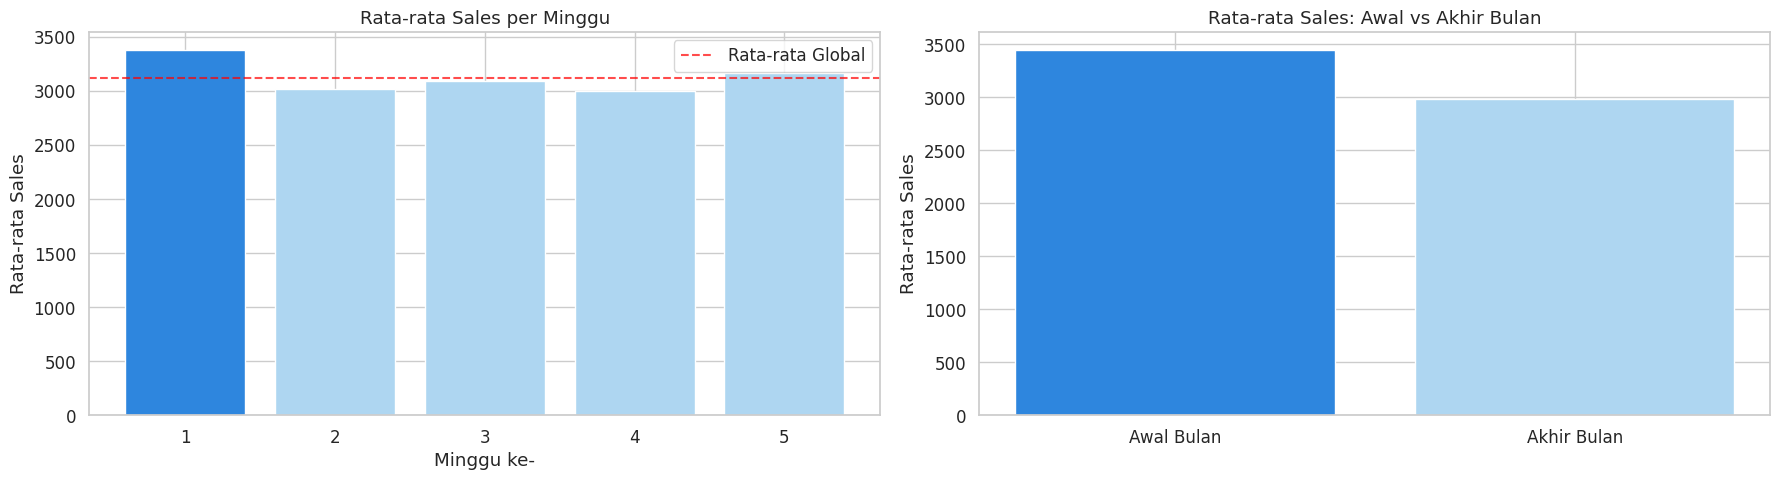

In [ ]:


sns.set(style="whitegrid", font_scale=1.1)

highlight_color = "#2E86DE"
base_color = "#AED6F1"

# ==== 1️⃣ Rata-rata sales per minggu ====
weekly_sales = grocery_adv.groupby('week_of_month')['sales'].mean().reset_index()
max_week = weekly_sales['sales'].idxmax()
mean_sales = grocery_adv['sales'].mean()

# ==== 2️⃣ Rata-rata sales awal vs akhir bulan ====
period_sales = {
    'Awal Bulan': grocery_adv.loc[grocery_adv['is_start_month']==1, 'sales'].mean(),
    'Akhir Bulan': grocery_adv.loc[grocery_adv['is_end_month']==1, 'sales'].mean()
}
period_df = pd.DataFrame(list(period_sales.items()), columns=['Periode', 'Sales'])
max_period = period_df.loc[period_df['Sales'].idxmax(), 'Periode']
colors_period = [highlight_color if p == max_period else base_color for p in period_df['Periode']]


# ==== Buat figure 2 kolom ====
fig, axes = plt.subplots(1, 2, figsize=(18,5))

# 1️⃣ Weekly
axes[0].bar(
    x=weekly_sales['week_of_month'],
    height=weekly_sales['sales'],
    color=[highlight_color if w == weekly_sales.loc[max_week, 'week_of_month'] else base_color
           for w in weekly_sales['week_of_month']]
)
axes[0].axhline(mean_sales, ls='--', color='red', alpha=0.7, label='Rata-rata Global')
axes[0].set_title("Rata-rata Sales per Minggu")
axes[0].set_xlabel("Minggu ke-")
axes[0].set_ylabel("Rata-rata Sales")
axes[0].legend()

# 2️⃣ Awal vs Akhir Bulan
axes[1].bar(period_df['Periode'], period_df['Sales'], color=colors_period)
axes[1].set_title("Rata-rata Sales: Awal vs Akhir Bulan")
axes[1].set_ylabel("Rata-rata Sales")


plt.tight_layout()
plt.show()

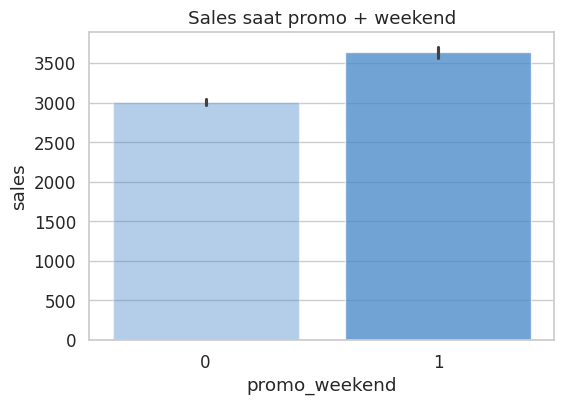

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(6,4))

bars = sns.barplot(x='promo_weekend', y='sales', data=grocery_adv, color='#2E86DE')  # semua biru

# Hitung max dan min sales
max_sales = grocery_adv['sales'].max()
min_sales = grocery_adv['sales'].min()

# Ubah alpha untuk setiap bar berdasarkan sales (lebih tinggi → lebih gelap)
for bar, sales in zip(bars.patches, grocery_adv['sales']):
    # alpha antara 0.4 (rendah) sampai 1 (tinggi)
    alpha = 0.4 + 0.6 * (sales - min_sales) / (max_sales - min_sales)
    bar.set_alpha(alpha)

plt.title("Sales saat promo + weekend")
plt.show()


### Stationary Data

#### Augmented Dickey-Fuller Test

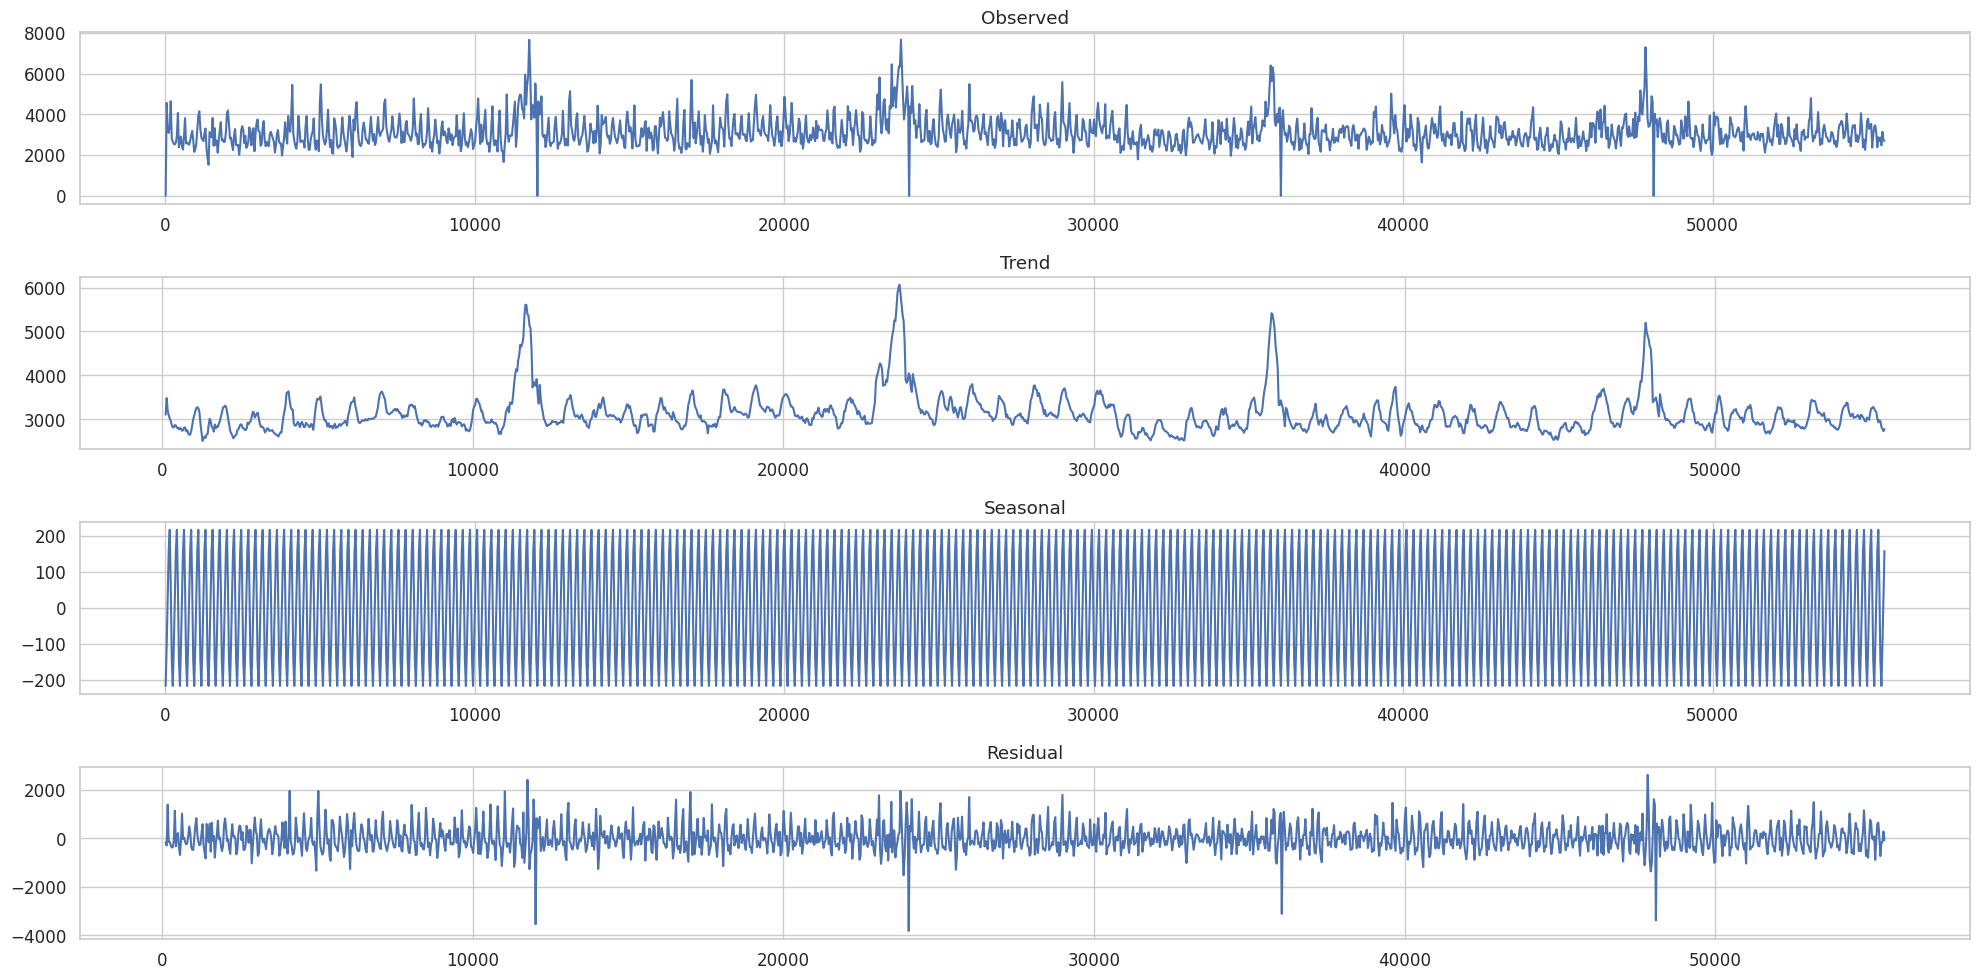

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

plot_decompose = seasonal_decompose(grocery['sales'], model='additive', period=7)

# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose.observed.plot(ax=ax1, title='Observed')
plot_decompose.trend.plot(ax=ax2, title='Trend')
plot_decompose.seasonal.plot(ax=ax3, title='Seasonal')
plot_decompose.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()


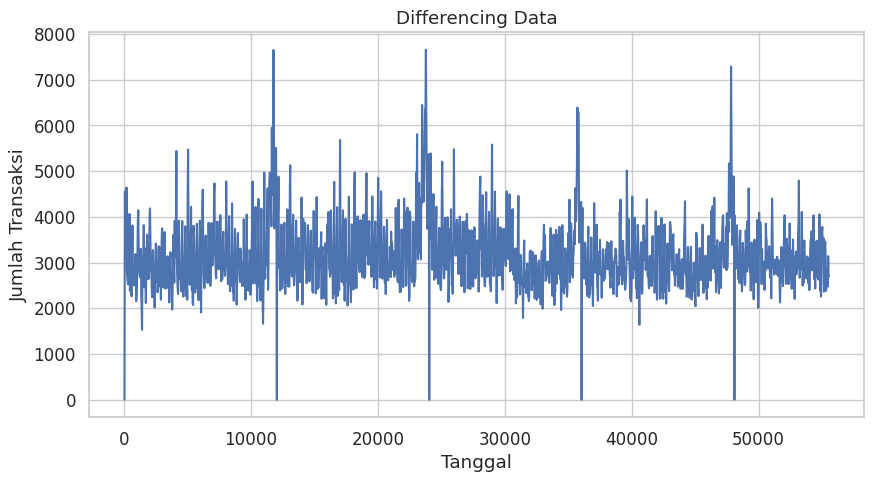

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(grocery['sales'].dropna())
plt.title('Differencing Data')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(grocery['sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.212414
p-value: 0.000000


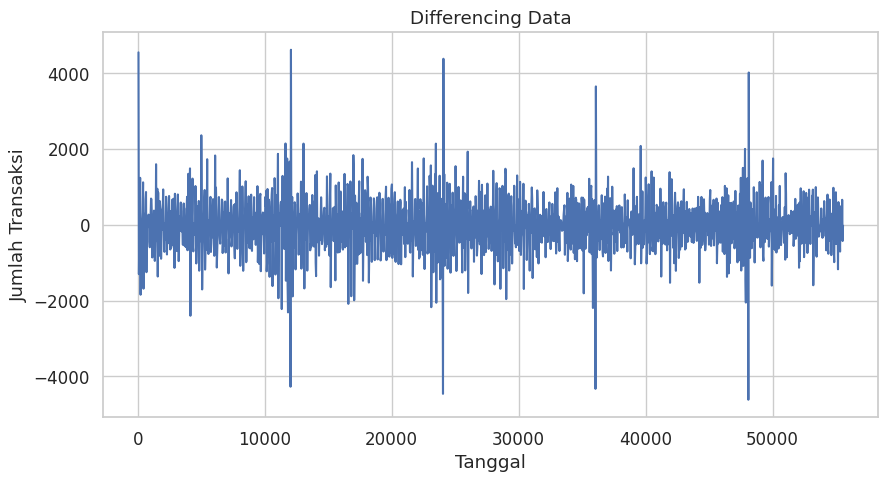

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(grocery['sales'].diff().dropna())
plt.title('Differencing Data')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(grocery['sales'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.704940
p-value: 0.000000


### Correlation and Feature Selection

In [ ]:
grocery_basic.drop(columns=['store_nbr', 'family', 'id'], inplace=True)

In [ ]:
grocery_adv.drop(columns=['store_nbr', 'family', 'id'], inplace=True)

#### Correlation and Feature Selection Basic FE

In [ ]:
grocery_basic.columns

Index(['date', 'sales', 'onpromotion', 'dcoilwtico', 'zero_block',
       'is_dcoilwtico_missing', 'year', 'month', 'day', 'dayofweek',
       'weekofyear', 'is_weekend', 'is_onpromotion', 'is_zero_sales'],
      dtype='object')

Kolom numerik kontinu: ['sales', 'onpromotion', 'dcoilwtico', 'weekofyear']
Kolom biner: ['zero_block', 'is_dcoilwtico_missing', 'is_weekend', 'is_onpromotion', 'is_zero_sales']


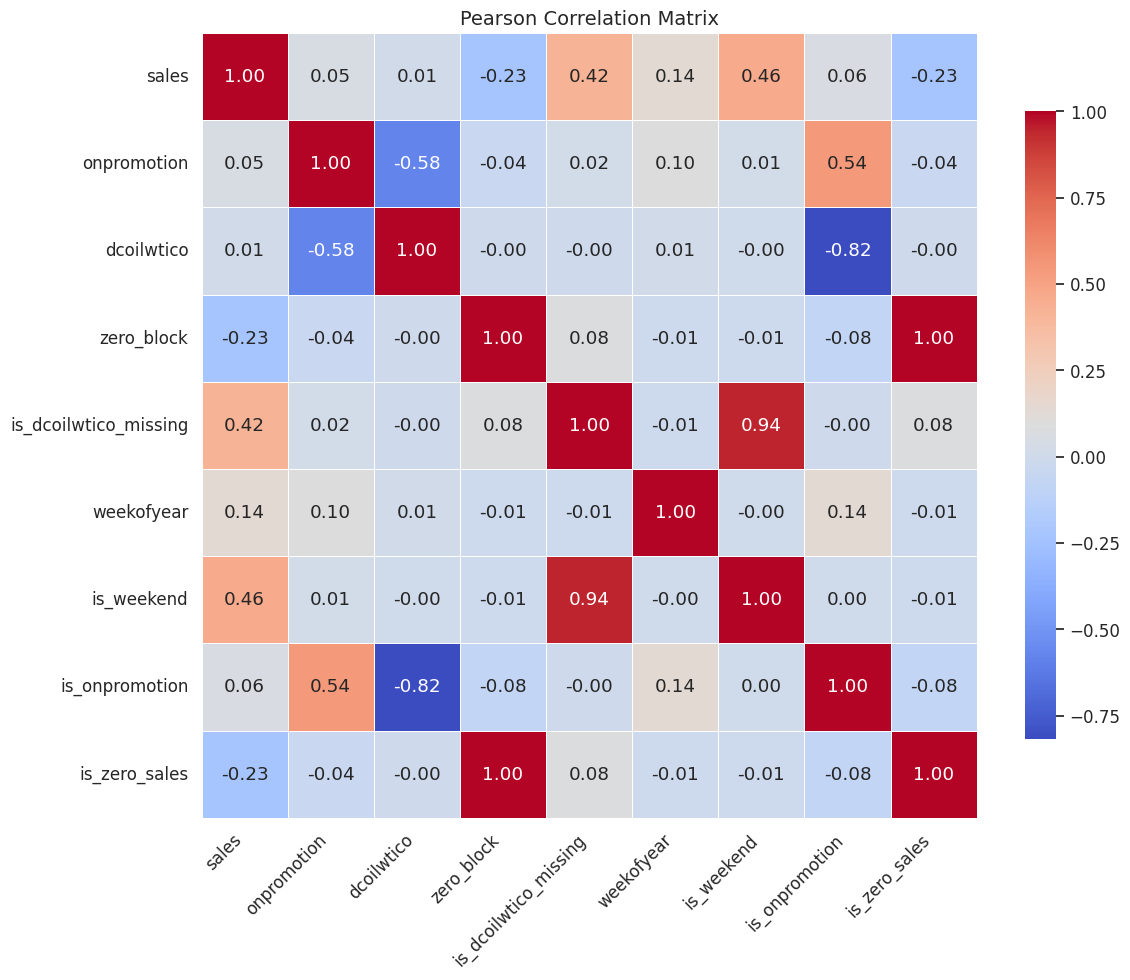

In [ ]:


# Pilih semua kolom numerik
numerical_cols = grocery_basic.select_dtypes(include=['int64','float64']).columns.tolist()

# Pisahkan kolom biner (0/1)
binary_cols = [col for col in numerical_cols if set(grocery_basic[col].dropna().unique()) <= {0,1}]
# Kolom numerik kontinu
numeric_continuous_cols = [col for col in numerical_cols if col not in binary_cols]

print("Kolom numerik kontinu:", numeric_continuous_cols)
print("Kolom biner:", binary_cols)

# Heatmap Pearson correlation (semua kolom numerik)
plt.figure(figsize=(12,10))
corr_matrix = grocery_basic[numerical_cols].corr(method='pearson')

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',   # merah-biru
    cbar_kws={'shrink':0.8},
    linewidths=0.5
)

plt.title("Pearson Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


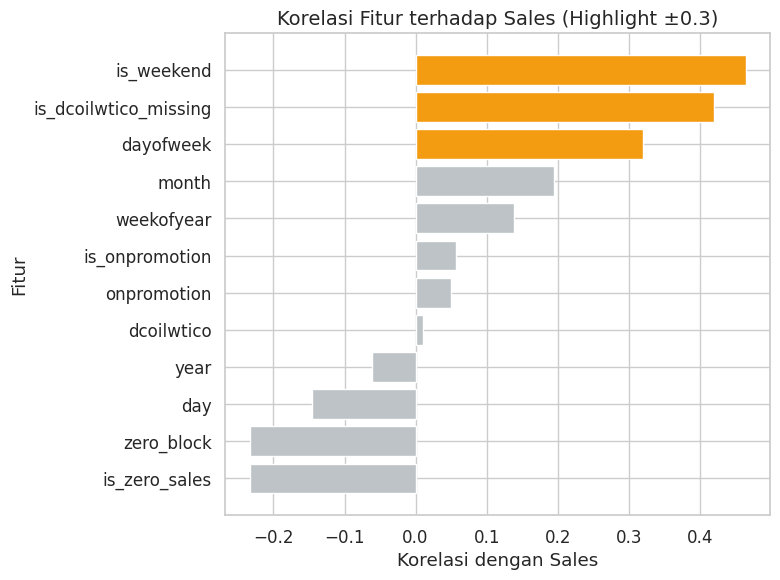

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1️⃣ Pilih kolom numerik / biner
# -------------------------------------------------
num_bin_cols = grocery_basic.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# -------------------------------------------------
# 2️⃣ Pilih kolom kategori untuk one-hot encode
# -------------------------------------------------
cat_cols = ['month', 'year', 'dayofweek', 'weekofyear']  # sesuaikan sesuai data

# One-hot encode kategori
df_cat = pd.get_dummies(grocery_basic[cat_cols], drop_first=True)

# -------------------------------------------------
# 3️⃣ Gabungkan numerik/biner dengan hasil one-hot
# -------------------------------------------------
df_all = pd.concat([grocery_basic[num_bin_cols], df_cat], axis=1)

# -------------------------------------------------
# 4️⃣ Hitung Pearson correlation
# -------------------------------------------------
corr_matrix = df_all.corr()

threshold = 0.3

# Korelasi asli
corr_with_sales_only = corr_matrix['sales'].drop('sales')
corr_with_sales_only = corr_with_sales_only[~corr_with_sales_only.index.duplicated(keep='first')]

# Urutkan dari positif ke negatif
corr_sorted = corr_with_sales_only.sort_values(ascending=False)

plt.figure(figsize=(8, max(6, len(corr_sorted)*0.3)))

# Horizontal bar chart, warna sesuai threshold
for i, (feat, val) in enumerate(corr_sorted.items()):
    color = '#F39C12' if val >= threshold or val <= -threshold else '#BDC3C7'
    plt.barh(i, val, color=color)

# Positif di atas, jadi invert y-axis
plt.yticks(range(len(corr_sorted)), corr_sorted.index)
plt.gca().invert_yaxis()

plt.xlabel("Korelasi dengan Sales")
plt.ylabel("Fitur")
plt.title(f"Korelasi Fitur terhadap Sales (Highlight ±{threshold})", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
selected_cols = corr_sorted[ (corr_sorted >= threshold) | (corr_sorted <= -threshold) ].index.tolist()

for col in ['sales', 'date']:
    if col not in selected_cols:
        selected_cols.append(col)
# Buat DataFrame baru hanya dengan selected_cols
df_grocery_basic = grocery_basic[selected_cols].copy()

df_grocery_basic['date'] = pd.to_datetime(df_grocery_basic['date'])
df_grocery_basic.set_index('date', inplace=True)

# Cek hasil
df_grocery_basic.head()

is_weekend  is_dcoilwtico_missing  dayofweek   sales
date                                                            
2013-01-01           0                      1          1     0.0
2013-01-02           0                      0          2  4558.0
2013-01-03           0                      0          3  3260.0
2013-01-04           0                      0          4  3085.0
2013-01-05           1                      1          5  3398.0

#### Correlation and Feature Selection Advance FE

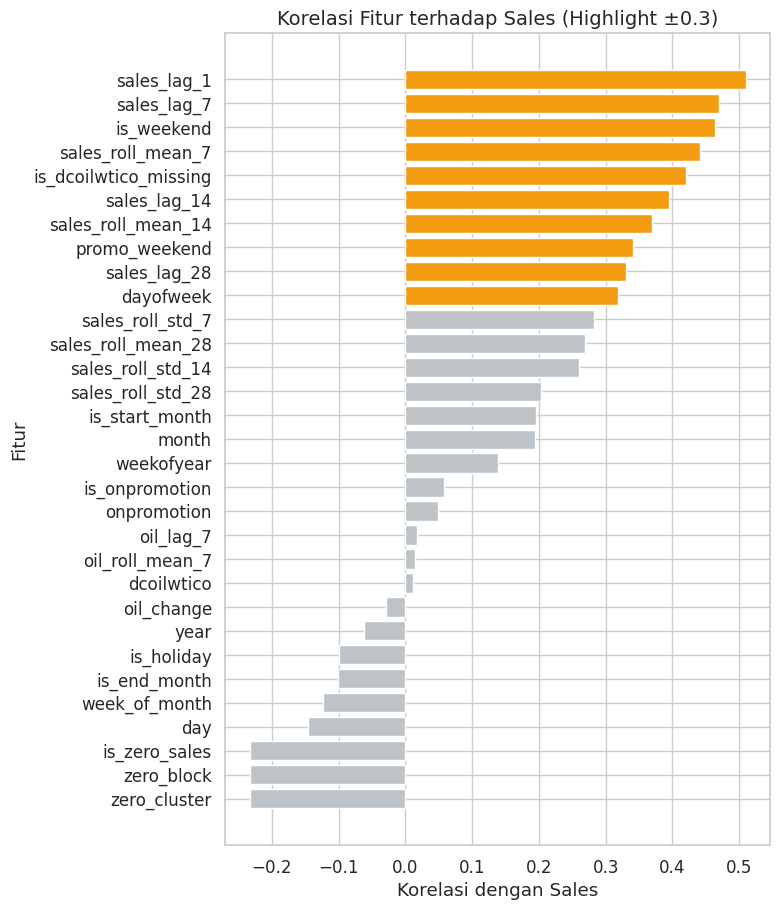

In [ ]:
# -------------------------------------------------
# 1️⃣ Pilih kolom numerik / biner
# -------------------------------------------------
num_bin_cols = grocery_adv.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# -------------------------------------------------
# 2️⃣ Pilih kolom kategori untuk one-hot encode
# -------------------------------------------------
cat_cols = ['month', 'year', 'dayofweek', 'weekofyear', 'week_of_month']  # sesuaikan sesuai data

# One-hot encode kategori
df_cat = pd.get_dummies(grocery_adv[cat_cols], drop_first=True)

# -------------------------------------------------
# 3️⃣ Gabungkan numerik/biner dengan hasil one-hot
# -------------------------------------------------
df_all = pd.concat([grocery_adv[num_bin_cols], df_cat], axis=1)

# -------------------------------------------------
# 4️⃣ Hitung Pearson correlation
# -------------------------------------------------
corr_matrix = df_all.corr()

threshold = 0.3

# Korelasi asli
corr_with_sales_only = corr_matrix['sales'].drop('sales')
corr_with_sales_only = corr_with_sales_only[~corr_with_sales_only.index.duplicated(keep='first')]

# Urutkan dari positif ke negatif
corr_sorted = corr_with_sales_only.sort_values(ascending=False)

plt.figure(figsize=(8, max(6, len(corr_sorted)*0.3)))

# Horizontal bar chart, warna sesuai threshold
for i, (feat, val) in enumerate(corr_sorted.items()):
    color = '#F39C12' if val >= threshold or val <= -threshold else '#BDC3C7'
    plt.barh(i, val, color=color)

# Positif di atas, jadi invert y-axis
plt.yticks(range(len(corr_sorted)), corr_sorted.index)
plt.gca().invert_yaxis()

plt.xlabel("Korelasi dengan Sales")
plt.ylabel("Fitur")
plt.title(f"Korelasi Fitur terhadap Sales (Highlight ±{threshold})", fontsize=14)
plt.tight_layout()
plt.show()

##### Selected Features Advance FE

In [ ]:
selected_cols = corr_sorted[ (corr_sorted >= threshold) | (corr_sorted <= -threshold) ].index.tolist()

for col in ['sales', 'date']:
    if col not in selected_cols:
        selected_cols.append(col)
# Buat DataFrame baru hanya dengan selected_cols
df_grocery_adv = grocery_adv[selected_cols].copy()

df_grocery_adv['date'] = pd.to_datetime(df_grocery_adv['date'])
df_grocery_adv.set_index('date', inplace=True)

# Cek hasil
df_grocery_adv.head()

sales_lag_1  sales_lag_7  is_weekend  sales_roll_mean_7  \
date                                                                  
2013-01-01          NaN          NaN           0                NaN   
2013-01-02          0.0          NaN           0                NaN   
2013-01-03       4558.0          NaN           0                NaN   
2013-01-04       3260.0          NaN           0                NaN   
2013-01-05       3085.0          NaN           1                NaN   

            is_dcoilwtico_missing  sales_lag_14  sales_roll_mean_14  \
date                                                                  
2013-01-01                      1           NaN                 NaN   
2013-01-02                      0           NaN                 NaN   
2013-01-03                      0           NaN                 NaN   
2013-01-04                      0           NaN                 NaN   
2013-01-05                      1           NaN                 NaN   

            promo_weekend  sales_lag_28  dayofweek   sales  
date                                                        
2013-01-01              0           NaN          1     0.0  
2013-01-02              0           NaN          2  4558.0  
2013-01-03              0           NaN          3  3260.0  
2013-01-04              0           NaN          4  3085.0  
2013-01-05              0           NaN          5  3398.0

### Train Test Split

###### Train Test Split SARIMA

In [ ]:
train_size = int(len(df_grocery_basic) * 0.8)

In [ ]:
train_sarima_uni = df_grocery_basic.iloc[:train_size]['sales']
test_sarima_uni = df_grocery_basic.iloc[train_size:]['sales']

#### Train Test Split Basic FE

In [ ]:
grocery_basic['date'] = pd.to_datetime(grocery_basic['date'])
grocery_basic.set_index('date', inplace=True)
train_basic = grocery_basic.iloc[:train_size]
test_basic = grocery_basic.iloc[train_size:]

In [ ]:
# =========================
# Pisahkan endog & exog
# =========================
train_endog_basic = train_basic['sales']
train_exog_basic = train_basic.drop(columns=['sales'])
test_endog_basic  = test_basic['sales']
test_exog_basic  = test_basic.drop(columns=['sales'])

# =========================
# Pastikan index exog align dengan endog
# =========================
train_exog_basic = train_exog_basic.loc[train_endog_basic.index]
test_exog_basic = test_exog_basic.loc[test_endog_basic.index]

#### Train Test Split Advance FE

In [ ]:
max_lag = 28
df_grocery_adv = df_grocery_adv.iloc[max_lag:].copy()


In [ ]:
train_adv = df_grocery_adv.iloc[:train_size] # Data latih yang ditransformasi
test_adv = df_grocery_adv.iloc[train_size:] # Data uji yang ditransformasi

In [ ]:
# =========================
# Pisahkan endog & exog
# =========================
train_endog_adv = train_adv['sales']
train_exog_adv = train_adv.drop(columns=['sales'])
test_endog_adv  = test_adv['sales']
test_exog_adv  = test_adv.drop(columns=['sales'])

# =========================
# Pastikan index exog align dengan endog
# =========================
train_exog_adv = train_exog_adv.loc[train_endog_adv.index]
test_exog_adv  = test_exog_adv.loc[test_endog_adv.index]

### Modeling

#### SARIMA/SARIMAX

##### ACF/PACF Plot

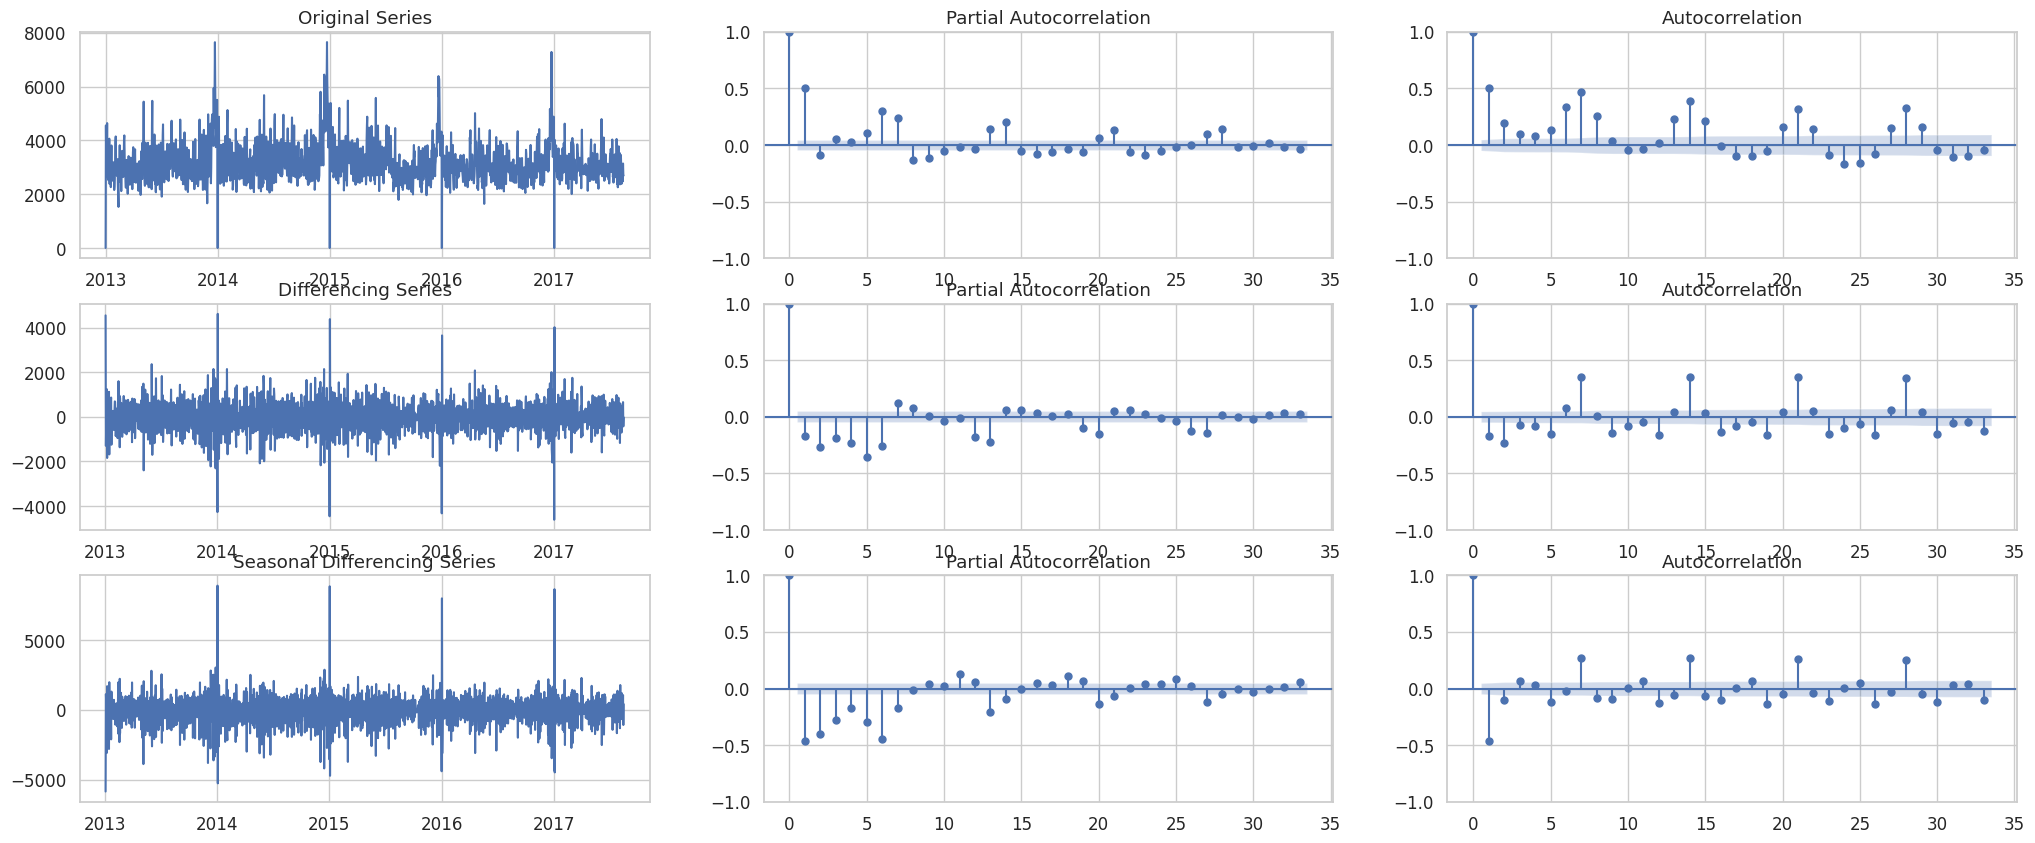

In [ ]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(3, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(df_grocery_basic['sales'])
ax[0, 1] = plot_pacf(df_grocery_basic['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(df_grocery_basic['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(df_grocery_basic['sales'].diff().dropna())
ax[1, 1] = plot_pacf(df_grocery_basic['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(df_grocery_basic['sales'].diff().dropna(), ax=ax[1, 2])

ax[2, 0].set_title('Seasonal Differencing Series')
ax[2, 0].plot(df_grocery_basic['sales'].diff().diff().dropna())
ax[2, 1] = plot_pacf(df_grocery_basic['sales'].diff().diff().dropna(), ax=ax[2, 1])
ax[2, 2] = plot_acf(df_grocery_basic['sales'].diff().diff().dropna(), ax=ax[2, 2])

plt.show()


##### Define Order (p, d, q)

###### Auto Arima

In [ ]:

s = 7  # weekly seasonality
auto_model = pm.auto_arima(
    train_sarima_uni,
    start_p=0, start_q=0,
    max_p=7, max_q=7,
    d=None,            # biarkan auto_arima tentukan d
    seasonal=True,     # SARIMA
    start_P=0, start_Q=0,
    max_P=3, max_Q=3,
    D=None,            # biarkan auto_arima tentukan D
    m=s,
    stepwise=False,     # fast search
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

# Summary model terbaik
print(auto_model.summary())

 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=21675.245, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=21445.383, Time=3.81 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=21331.928, Time=4.50 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=21659.826, Time=1.17 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.25 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=21336.061, Time=8.36 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=21657.312, Time=2.83 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=21293.522, Time=7.74 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=21302.559, Time=6.77 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=21274.038, Time=0.81 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=21127.229, Time=1.17 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=21044.113, Time=2.16 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=21243.044, Time=2.47 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.87 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=21044.848, Time=4.60 sec
 ARIMA(

###### SARIMA

In [ ]:
# Seasoaonal SARIMA Model
# model_sarima = SARIMAX(train_sarima_uni, order=(2,0,1), seasonal_order=(1,0,1,7))
model_sarima = SARIMAX(train_sarima_uni, order=(3,0,3), seasonal_order=(1,0,1,7))
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1347
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 7)   Log Likelihood              -10389.307
Date:                             Mon, 13 Oct 2025   AIC                          20796.614
Time:                                     04:49:05   BIC                          20843.464
Sample:                                          0   HQIC                         20814.161
                                            - 1347                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0683      0.152     13.576      0.000       1.770       2.367
ar.L2         -1.2233      

Evaluation

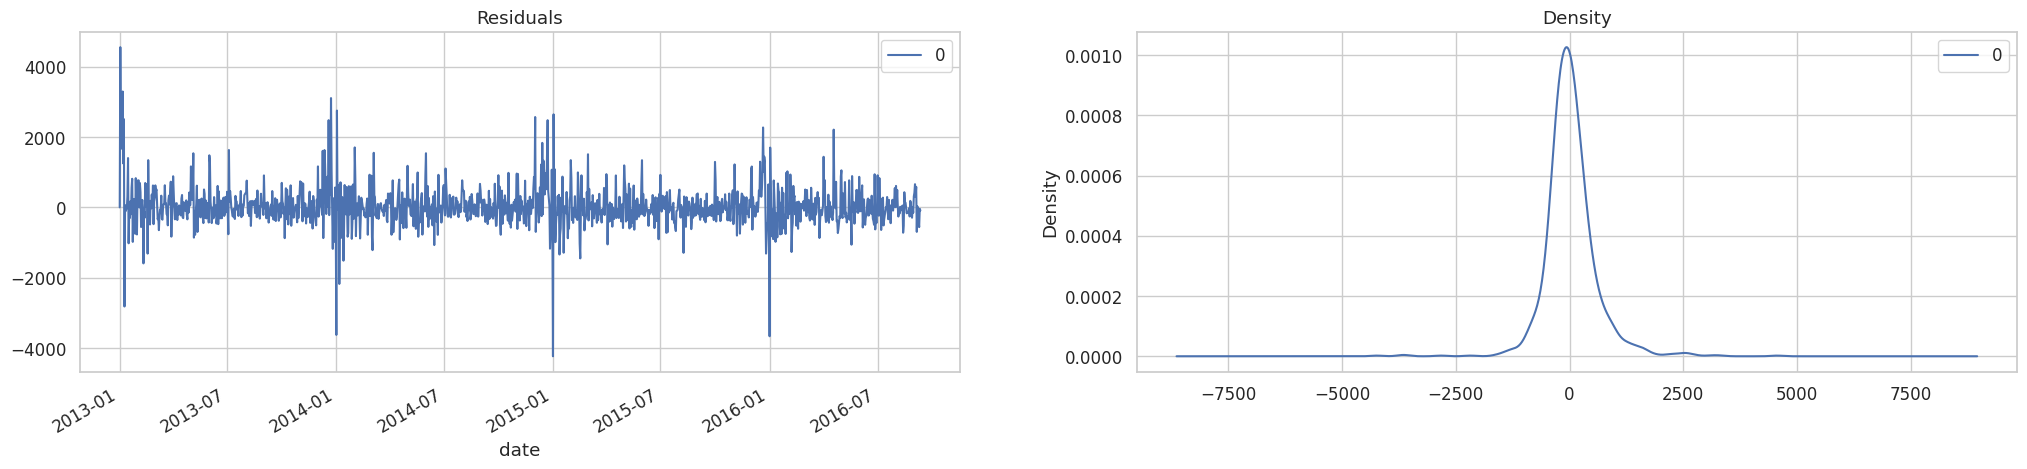

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_sarima_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forecast_sarima_uni = model_sarima_fit.predict(start=len(train_sarima_uni), end=len(train_sarima_uni)+len(test_sarima_uni)-1, typ='levels')

forecast_sarima_uni.index = test_sarima_uni.index

y_true = test_sarima_uni
y_pred = forecast_sarima_uni
y_pred = pd.Series(y_pred, index=y_true.index)

# -------------------------------
# Hitung metrik
# -------------------------------
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

def calculate_mape(y_true, y_pred):
    nonzero_mask = y_true != 0
    if not np.any(nonzero_mask):
        return np.nan
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = calculate_mape(y_true, y_pred)

def calculate_smape(y_true, y_pred):
    mask = (y_true != 0) | (y_pred != 0)
    if not np.any(mask):
        return np.nan
    return 100 * np.mean(
        2 * np.abs(y_pred[mask] - y_true[mask]) / (np.abs(y_true[mask]) + np.abs(y_pred[mask]))
    )

smape = calculate_smape(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# -------------------------------
# Buat tabel evaluasi
# -------------------------------
eval_table_sarima= pd.DataFrame({
    'Algorithm': ['SARIMA'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'SMAPE (%)': [smape],
    'R2': [r2]
})

# Tampilkan tabel
eval_table_sarima.style.background_gradient(cmap='Blues', subset=['MAE','MSE','RMSE','MAPE (%)','SMAPE (%)', 'R2'])

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
import joblib
# -------------------------------
# Simpan model
# -------------------------------
joblib.dump(model_sarima_fit, '/content/drive/MyDrive/Proyek/project1/model/sarima_model.pkl')
print("Model SARIMA tersimpan sebagai sarima_model.pkl")

Model SARIMA tersimpan sebagai sarima_model.pkl


Forecasting

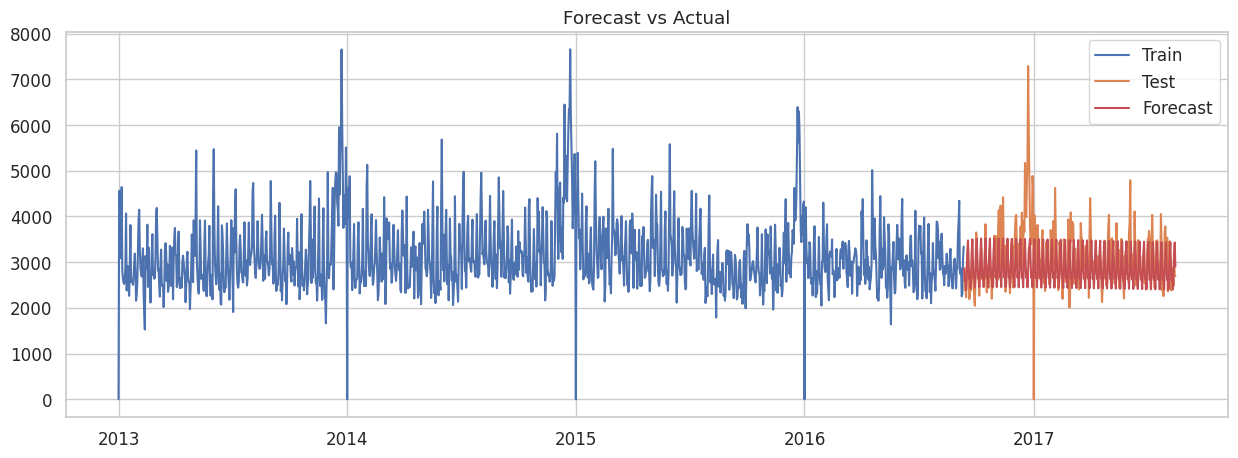

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(train_sarima_uni, label='Train')
plt.plot(test_sarima_uni, label='Test')
plt.plot(forecast_sarima_uni, label='Forecast', color='r')
plt.legend()
plt.show()


###### SARIMAX Basic FE

In [ ]:
p, d, q = 3, 0, 3
P, D, Q, s = 1, 0, 1, 7

# Build SARIMAX model
model_sarimax_basic = SARIMAX(
    train_endog_basic,
    exog=train_exog_basic,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_sarimax_basic_fit = model_sarimax_basic.fit(disp=False)
print(model_sarimax_basic_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1347
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 7)   Log Likelihood              -10099.900
Date:                             Mon, 13 Oct 2025   AIC                          20241.799
Time:                                     04:50:12   BIC                          20350.946
Sample:                                          0   HQIC                         20282.696
                                            - 1347                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
onpromotion              -2.0544      1.990     -1.032      0.302      -5.955       

In [ ]:
# 1️⃣ Forecasting SARIMAX
start = len(train_endog_basic)
end = start + len(test_endog_basic) - 1
forecast_sarimax_basic = model_sarimax_basic_fit.predict(
    start=start,  # mulai dari index test set
    end=end,   # sampai index test set terakhir
    exog=test_exog_basic,
    typ='levels'

)

# Samakan index dengan test set
forecast_sarimax_basic.index = test_endog_basic.index

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Evaluation

In [ ]:
from sklearn.metrics import r2_score


y_true = test_endog_basic
y_pred = forecast_sarimax_basic
y_pred = pd.Series(y_pred, index=y_true.index)

# -------------------------------
# Hitung metrik
# -------------------------------
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

def calculate_mape(y_true, y_pred):
    nonzero_mask = y_true != 0
    if not np.any(nonzero_mask):
        return np.nan
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = calculate_mape(y_true, y_pred)

def calculate_smape(y_true, y_pred):
    mask = (y_true != 0) | (y_pred != 0)
    if not np.any(mask):
        return np.nan
    return 100 * np.mean(
        2 * np.abs(y_pred[mask] - y_true[mask]) / (np.abs(y_true[mask]) + np.abs(y_pred[mask]))
    )

smape = calculate_smape(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# -------------------------------
# Buat tabel evaluasi
# -------------------------------
eval_table_sarimax_basic_fe = pd.DataFrame({
    'Algorithm': ['SARIMAX BASIC FE'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'SMAPE (%)': [smape],
    'R2': [r2]
})

# Tampilkan tabel
eval_table_sarimax_basic_fe.style.background_gradient(cmap='Blues', subset=['MAE','MSE','RMSE','MAPE (%)','SMAPE (%)', 'R2'])

Forecasting

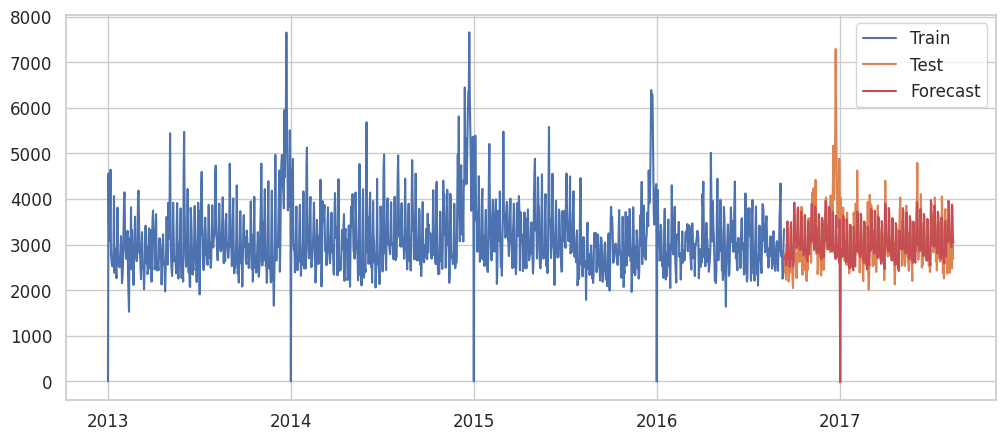

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_endog_basic, label='Train')
plt.plot(test_endog_basic, label='Test')
plt.plot(forecast_sarimax_basic, label='Forecast', color='r')
plt.legend()
plt.show()


In [ ]:
# -------------------------------
# Simpan model
# -------------------------------
joblib.dump(model_sarimax_basic_fit, '/content/drive/MyDrive/Proyek/project1/model/sarimax_basic_fe_model.pkl')
print("Model SARIMAX tersimpan sebagai sarimax_basic_fe_model.pkl")

Model SARIMAX tersimpan sebagai sarimax_basic_fe_model.pkl


###### SARIMAX Advance FE

In [ ]:

p, d, q = 3, 0, 3
P, D, Q, s = 1, 0, 1, 7

# Build SARIMAX model
model_sarimax_adv = SARIMAX(
    train_endog_adv,
    exog=train_exog_adv,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_sarimax_adv_fit = model_sarimax_adv.fit(disp=False)
print(model_sarimax_adv_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1347
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 7)   Log Likelihood              -10190.690
Date:                             Mon, 13 Oct 2025   AIC                          20419.380
Time:                                     04:50:38   BIC                          20518.132
Sample:                                          0   HQIC                         20456.382
                                            - 1347                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sales_lag_1               0.4520      0.066      6.830      0.000       0.322       

In [ ]:
# 1️⃣ Forecasting SARIMAX
start = len(train_endog_adv)
end = start + len(test_endog_adv) - 1
forecast_sarimax_adv = model_sarimax_adv_fit.predict(
    start=start,  # mulai dari index test set
    end=end,   # sampai index test set terakhir
    exog=test_exog_adv,
    typ='levels'

)

# Samakan index dengan test set
forecast_sarimax_adv.index = test_endog_adv.index

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Evaluation

In [ ]:
from sklearn.metrics import r2_score


y_true = test_endog_adv
y_pred = forecast_sarimax_adv
y_pred = pd.Series(y_pred, index=y_true.index)

# -------------------------------
# Hitung metrik
# -------------------------------
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

def calculate_mape(y_true, y_pred):
    nonzero_mask = y_true != 0
    if not np.any(nonzero_mask):
        return np.nan
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = calculate_mape(y_true, y_pred)

def calculate_smape(y_true, y_pred):
    mask = (y_true != 0) | (y_pred != 0)
    if not np.any(mask):
        return np.nan
    return 100 * np.mean(
        2 * np.abs(y_pred[mask] - y_true[mask]) / (np.abs(y_true[mask]) + np.abs(y_pred[mask]))
    )

smape = calculate_smape(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# -------------------------------
# Buat tabel evaluasi
# -------------------------------
eval_table_sarimax_adv_fe = pd.DataFrame({
    'Algorithm': ['SARIMAX ADV FE'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'SMAPE (%)': [smape],
    'R2': [r2]
})

# Tampilkan tabel
eval_table_sarimax_adv_fe.style.background_gradient(cmap='Blues', subset=['MAE','MSE','RMSE','MAPE (%)','SMAPE (%)', 'R2'])

Forecasting

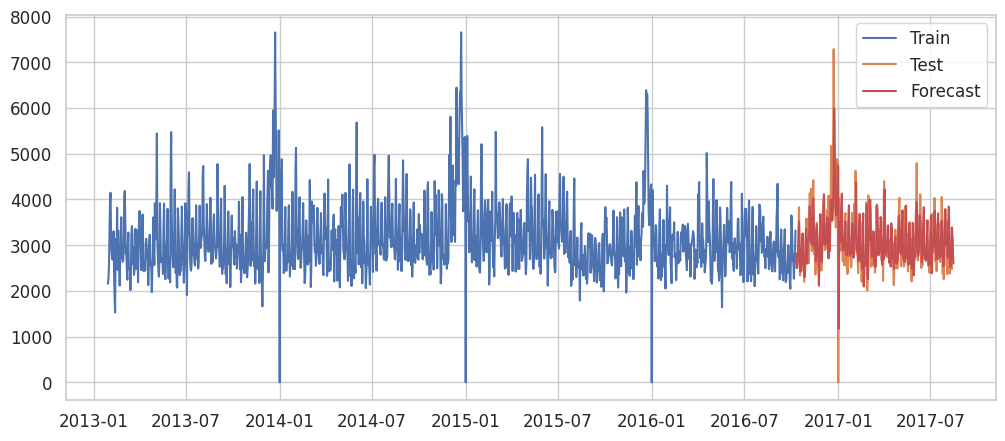

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train_endog_adv, label='Train')
plt.plot(test_endog_adv, label='Test')
plt.plot(forecast_sarimax_adv, label='Forecast', color='r')
plt.legend()
plt.show()


In [ ]:
# -------------------------------
# Simpan model
# -------------------------------
joblib.dump(model_sarimax_adv_fit, '/content/drive/MyDrive/Proyek/project1/model/sarimax_adv_fe_model.pkl')
print("Model SARIMAX tersimpan sebagai sarimax_adv_fe_model.pkl")

Model SARIMAX tersimpan sebagai sarimax_adv_fe_model.pkl


#### LSTM

###### LSTM Univariate

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# log transform
train_log = np.log1p(train_sarima_uni.values.reshape(-1,1))
test_log  = np.log1p(test_sarima_uni.values.reshape(-1,1))

# scaling setelah log
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_log)
test_scaled  = scaler.transform(test_log)

In [ ]:
look_back = 14

def create_univariate_dataset(data, look_back=14):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_univariate_dataset(train_scaled, look_back)
X_test, y_test   = create_univariate_dataset(test_scaled, look_back)

# reshape untuk LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# ---------------------------
# 5️⃣ Optuna Hyperparameter Tuning
# ---------------------------
def objective(trial):
    n_units = trial.suggest_int('n_units', 10, 100)
    lr      = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout_rate = trial.suggest_float('dropout', 0.0, 0.3)

    model = Sequential()
    model.add(LSTM(n_units, activation='tanh', input_shape=(look_back,1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mae')

    # early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.2, epochs=50,
              batch_size=batch_size,
              # callbacks=[early_stop],
              verbose=1)

    # Predict test set
    y_pred = model.predict(X_test)
    # inverse scaling
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-10-13 04:50:54,268] A new study created in memory with name: no-name-5e1f80f1-629f-4eb2-a82f-bfd93d983185
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2878 - val_loss: 0.0466
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0802 - val_loss: 0.0436
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0705 - val_loss: 0.0435
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0800 - val_loss: 0.0525
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0755 - val_loss: 0.0486
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0621 - val_loss: 0.0421
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0586 - val_loss: 0.0490
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0706 - val_loss: 0.0418
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0572 - val_loss: 0.0416
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0583 - val_loss: 0.0415
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0586 - val_loss: 0.0427
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

[I 2025-10-13 04:51:45,670] Trial 0 finished with value: 0.48695435517497704 and parameters: {'n_units': 90, 'lr': 0.0010111234215961443, 'batch_size': 16, 'dropout': 0.25398091060696404}. Best is trial 0 with value: 0.48695435517497704.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.6537 - val_loss: 0.0438
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0779 - val_loss: 0.0479
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0558 - val_loss: 0.0452
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0583 - val_loss: 0.0445
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0587 - val_loss: 0.0431
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0563 - val_loss: 0.0428
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0536 - val_loss: 0.0434
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0539 - val_loss: 0.0460
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0547 - val_loss: 0.0458
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0598 - val_loss: 0.0436
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0566 - val_loss: 0.0428
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0519 - val_l

[I 2025-10-13 04:52:17,253] Trial 1 finished with value: 0.4965929730311527 and parameters: {'n_units': 81, 'lr': 0.0002589786131528382, 'batch_size': 32, 'dropout': 0.0988252420878581}. Best is trial 0 with value: 0.48695435517497704.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.3188 - val_loss: 0.0599
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0858 - val_loss: 0.0439
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0690 - val_loss: 0.0477
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0675 - val_loss: 0.0463
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0686 - val_loss: 0.0459
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0728 - val_loss: 0.0487
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0599 - val_loss: 0.0449
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0675 - val_loss: 0.0429
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0623 - val_loss: 0.0506
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0628 - val_loss: 0.0425
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0654 - val_loss: 0.0493
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0644 - val_l

[I 2025-10-13 04:52:45,362] Trial 2 finished with value: 0.48702689623203166 and parameters: {'n_units': 36, 'lr': 0.0016678876673521337, 'batch_size': 32, 'dropout': 0.15574571383704236}. Best is trial 0 with value: 0.48695435517497704.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.7429 - val_loss: 0.3147
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2070 - val_loss: 0.0763
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1415 - val_loss: 0.0684
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1278 - val_loss: 0.0424
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1129 - val_loss: 0.0523
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1091 - val_loss: 0.0436
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1046 - val_loss: 0.0425
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0982 - val_loss: 0.0438
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0970 - val_loss: 0.0501
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0879 - val_loss: 0.0492
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0957 - val_loss: 0.0473
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0927 - val_l

[I 2025-10-13 04:53:01,681] Trial 3 finished with value: 0.48924282152543686 and parameters: {'n_units': 23, 'lr': 0.001188336307152233, 'batch_size': 64, 'dropout': 0.2565908902190838}. Best is trial 0 with value: 0.48695435517497704.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6350 - val_loss: 0.0446
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0852 - val_loss: 0.0426
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0718 - val_loss: 0.0428
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0670 - val_loss: 0.0430
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0657 - val_loss: 0.0446
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0624 - val_loss: 0.0465
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0618 - val_loss: 0.0460
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0609 - val_loss: 0.0429
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0583 - val_loss: 0.0427
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0581 - val_loss: 0.0440
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0603 - val_loss: 0.0498
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0564 - val_l

[I 2025-10-13 04:53:35,113] Trial 4 finished with value: 0.4918122008461131 and parameters: {'n_units': 79, 'lr': 0.00042843563380662883, 'batch_size': 32, 'dropout': 0.1959547728847356}. Best is trial 0 with value: 0.48695435517497704.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.4926 - val_loss: 0.0570
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0813 - val_loss: 0.0527
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0729 - val_loss: 0.0434
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0718 - val_loss: 0.0483
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0582 - val_loss: 0.0435
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0630 - val_loss: 0.0452
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0611 - val_loss: 0.0453
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0664 - val_loss: 0.0433
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0631 - val_loss: 0.0426
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0638 - val_loss: 0.0538
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0575 - val_loss: 0.0424
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0616 - val_l

[I 2025-10-13 04:53:54,329] Trial 5 finished with value: 0.4870002626166037 and parameters: {'n_units': 59, 'lr': 0.0029164287724047304, 'batch_size': 64, 'dropout': 0.2033554711710084}. Best is trial 0 with value: 0.48695435517497704.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.5384 - val_loss: 0.4437
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4059 - val_loss: 0.2564
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2039 - val_loss: 0.0702
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1620 - val_loss: 0.0571
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1510 - val_loss: 0.0540
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1432 - val_loss: 0.0672
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1461 - val_loss: 0.0557
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1462 - val_loss: 0.0448
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1360 - val_loss: 0.0461
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1378 - val_loss: 0.0580
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1346 - val_loss: 0.0574
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1313 - val_loss: 0.

[I 2025-10-13 04:54:32,295] Trial 6 finished with value: 0.49616466842482676 and parameters: {'n_units': 13, 'lr': 0.0001431084905244728, 'batch_size': 16, 'dropout': 0.25653357338956134}. Best is trial 0 with value: 0.48695435517497704.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1953 - val_loss: 0.0432
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0664 - val_loss: 0.0512
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0681 - val_loss: 0.0411
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0635 - val_loss: 0.0407
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0568 - val_loss: 0.0411
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0557 - val_loss: 0.0403
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0491 - val_loss: 0.0401
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0522 - val_loss: 0.0501
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0498 - val_loss: 0.0455
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0504 - val_loss: 0.0398
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0532 - val_loss: 0.0425
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0482 - val_l

[I 2025-10-13 04:55:24,412] Trial 7 finished with value: 0.48403568391862156 and parameters: {'n_units': 93, 'lr': 0.004351375563945734, 'batch_size': 16, 'dropout': 0.28875678678385636}. Best is trial 7 with value: 0.48403568391862156.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2469 - val_loss: 0.0463
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0758 - val_loss: 0.0425
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0601 - val_loss: 0.0417
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0577 - val_loss: 0.0678
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0639 - val_loss: 0.0489
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0573 - val_loss: 0.0431
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0724 - val_loss: 0.0473
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0542 - val_loss: 0.0489
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0595 - val_loss: 0.0438
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0536 - val_loss: 0.0415
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0550 - val_loss: 0.0403
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0473 - val_loss: 0.043

[I 2025-10-13 04:56:02,852] Trial 8 finished with value: 0.49069221933012674 and parameters: {'n_units': 32, 'lr': 0.0030628465739150385, 'batch_size': 16, 'dropout': 0.12381337111602395}. Best is trial 7 with value: 0.48403568391862156.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3718 - val_loss: 0.0452
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0897 - val_loss: 0.0531
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0801 - val_loss: 0.0441
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0689 - val_loss: 0.0436
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0695 - val_loss: 0.0462
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0625 - val_loss: 0.0437
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0616 - val_loss: 0.0447
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0655 - val_loss: 0.0439
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0658 - val_loss: 0.0435
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0645 - val_loss: 0.0426
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0668 - val_loss: 0.0426
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0603 - val_l

[I 2025-10-13 04:56:26,918] Trial 9 finished with value: 0.4893378793798969 and parameters: {'n_units': 72, 'lr': 0.0019118732922302159, 'batch_size': 64, 'dropout': 0.26156199206069863}. Best is trial 7 with value: 0.48403568391862156.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1926 - val_loss: 0.0495
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0429 - val_loss: 0.0526
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0429 - val_loss: 0.0458
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0446 - val_loss: 0.0445
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0434 - val_loss: 0.0409
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0402 - val_loss: 0.0376
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0417 - val_loss: 0.0401
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0442 - val_loss: 0.0374
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0362 - val_loss: 0.0366
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0359 - val_loss: 0.0366
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0391 - val_loss: 0.0384
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0373 - val_l

[I 2025-10-13 04:57:19,380] Trial 10 finished with value: 0.4773522455300158 and parameters: {'n_units': 100, 'lr': 0.009924307463176804, 'batch_size': 16, 'dropout': 0.004579511342005738}. Best is trial 10 with value: 0.4773522455300158.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2595 - val_loss: 0.0550
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0471 - val_loss: 0.0508
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0469 - val_loss: 0.0397
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0441 - val_loss: 0.0393
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0478 - val_loss: 0.0388
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0412 - val_loss: 0.0382
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0362 - val_loss: 0.0397
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0431 - val_loss: 0.0435
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0407 - val_loss: 0.0427
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0403 - val_loss: 0.0400
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0360 - val_loss: 0.0372
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0393 - val_l

[I 2025-10-13 04:58:11,557] Trial 11 finished with value: 0.47759229708708223 and parameters: {'n_units': 100, 'lr': 0.008708795341507973, 'batch_size': 16, 'dropout': 0.016559456015763974}. Best is trial 10 with value: 0.4773522455300158.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2313 - val_loss: 0.0418
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0433 - val_loss: 0.0444
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0442 - val_loss: 0.0401
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0372 - val_loss: 0.0397
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0399 - val_loss: 0.0393
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0429 - val_loss: 0.0442
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0510 - val_loss: 0.0383
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0419 - val_loss: 0.0413
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0457 - val_loss: 0.0375
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0388 - val_loss: 0.0372
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0388 - val_loss: 0.0371
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0342 - val_l

[I 2025-10-13 04:59:08,091] Trial 12 finished with value: 0.4784744346962007 and parameters: {'n_units': 100, 'lr': 0.008767065133296852, 'batch_size': 16, 'dropout': 0.011016042945131869}. Best is trial 10 with value: 0.4773522455300158.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1697 - val_loss: 0.0510
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0477 - val_loss: 0.0407
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0437 - val_loss: 0.0416
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0396 - val_loss: 0.0449
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0476 - val_loss: 0.0426
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0454 - val_loss: 0.0494
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0392 - val_loss: 0.0414
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0462 - val_loss: 0.0376
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0363 - val_loss: 0.0420
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0371 - val_loss: 0.0502
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0375 - val_loss: 0.0369
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0381 - val_l

[I 2025-10-13 04:59:53,245] Trial 13 finished with value: 0.4816347441455207 and parameters: {'n_units': 57, 'lr': 0.009840771915352839, 'batch_size': 16, 'dropout': 0.005201006649896551}. Best is trial 10 with value: 0.4773522455300158.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2167 - val_loss: 0.0454
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0474 - val_loss: 0.0468
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0518 - val_loss: 0.0411
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0518 - val_loss: 0.0456
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0498 - val_loss: 0.0417
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0443 - val_loss: 0.0401
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0501 - val_loss: 0.0428
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0448 - val_loss: 0.0407
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0445 - val_loss: 0.0392
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0459 - val_loss: 0.0411
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0455 - val_loss: 0.0408
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0469 - val_l

[I 2025-10-13 05:00:39,297] Trial 14 finished with value: 0.49500641598065315 and parameters: {'n_units': 69, 'lr': 0.005566026035293001, 'batch_size': 16, 'dropout': 0.05187091200089893}. Best is trial 10 with value: 0.4773522455300158.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2058 - val_loss: 0.0501
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0479 - val_loss: 0.0410
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0518 - val_loss: 0.0407
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0489 - val_loss: 0.0432
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0489 - val_loss: 0.0470
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0472 - val_loss: 0.0441
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0446 - val_loss: 0.0450
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0459 - val_loss: 0.0396
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0460 - val_loss: 0.0423
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0409 - val_loss: 0.0402
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0484 - val_loss: 0.0409
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0445 - val_l

[I 2025-10-13 05:01:31,856] Trial 15 finished with value: 0.4870571640130168 and parameters: {'n_units': 100, 'lr': 0.006215739404655693, 'batch_size': 16, 'dropout': 0.06193540708766529}. Best is trial 10 with value: 0.4773522455300158.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1538 - val_loss: 0.0454
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0538 - val_loss: 0.0489
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0503 - val_loss: 0.0419
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0572 - val_loss: 0.0483
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0457 - val_loss: 0.0395
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0415 - val_loss: 0.0398
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0485 - val_loss: 0.0379
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0396 - val_loss: 0.0374
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0365 - val_loss: 0.0416
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0407 - val_loss: 0.0385
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0429 - val_loss: 0.0450
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0393 - val_loss

[I 2025-10-13 05:02:14,508] Trial 16 finished with value: 0.48203568482089004 and parameters: {'n_units': 46, 'lr': 0.00988445501634898, 'batch_size': 16, 'dropout': 0.04436991323439386}. Best is trial 10 with value: 0.4773522455300158.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2047 - val_loss: 0.0505
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0526 - val_loss: 0.0438
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0543 - val_loss: 0.0425
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0530 - val_loss: 0.0427
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0534 - val_loss: 0.0436
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0503 - val_loss: 0.0412
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0489 - val_loss: 0.0437
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0489 - val_loss: 0.0568
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0458 - val_loss: 0.0417
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0479 - val_loss: 0.0427
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0521 - val_loss: 0.0394
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0418 - val_l

[I 2025-10-13 05:03:02,181] Trial 17 finished with value: 0.4910131568601329 and parameters: {'n_units': 86, 'lr': 0.0036216560637635327, 'batch_size': 16, 'dropout': 0.09127357318401372}. Best is trial 10 with value: 0.4773522455300158.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.6195 - val_loss: 0.1284
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0892 - val_loss: 0.0709
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0577 - val_loss: 0.0434
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0508 - val_loss: 0.0429
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0496 - val_loss: 0.0431
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0509 - val_loss: 0.0456
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0490 - val_loss: 0.0430
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0485 - val_loss: 0.0431
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0462 - val_loss: 0.0428
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0471 - val_loss: 0.0429
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0452 - val_loss: 0.0428
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0446 - val_l

[I 2025-10-13 05:03:26,756] Trial 18 finished with value: 0.49551905179183164 and parameters: {'n_units': 68, 'lr': 0.0005235045725444671, 'batch_size': 64, 'dropout': 0.028504409441690245}. Best is trial 10 with value: 0.4773522455300158.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1925 - val_loss: 0.0432
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0504 - val_loss: 0.0428
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0480 - val_loss: 0.0447
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0528 - val_loss: 0.0514
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0479 - val_loss: 0.0476
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0512 - val_loss: 0.0422
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0515 - val_loss: 0.0423
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0472 - val_loss: 0.0490
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0503 - val_loss: 0.0494
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0520 - val_loss: 0.0487
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0480 - val_loss: 0.0423
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0450 - val_l

[I 2025-10-13 05:04:02,208] Trial 19 finished with value: 0.5074956433645135 and parameters: {'n_units': 91, 'lr': 0.002340310768794631, 'batch_size': 32, 'dropout': 0.08105973875294849}. Best is trial 10 with value: 0.4773522455300158.


Best hyperparameters: {'n_units': 100, 'lr': 0.009924307463176804, 'batch_size': 16, 'dropout': 0.004579511342005738}
Best RMSE: 0.4773522455300158


In [ ]:
# ---------------------------
# 6️⃣ Train Final Model
# ---------------------------
best_params = study.best_params

model_lstm_uni = Sequential()
model_lstm_uni.add(LSTM(best_params['n_units'], activation='tanh', input_shape=(look_back,1)))
model_lstm_uni.add(Dropout(best_params['dropout']))
model_lstm_uni.add(Dense(1))
model_lstm_uni.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mae')

# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_lstm_uni.fit(X_train, y_train, validation_split=0.2, epochs=50,
                          batch_size=best_params['batch_size'],
                            #  callbacks=[early_stop],
                             verbose=1)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1726 - val_loss: 0.0409
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0476 - val_loss: 0.0425
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0401 - val_loss: 0.0398
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0463 - val_loss: 0.0440
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0374 - val_loss: 0.0426
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0387 - val_loss: 0.0445
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0467 - val_loss: 0.0420
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0375 - val_loss: 0.0414
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0436 - val_loss: 0.0453
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0368 - val_loss: 0.0482
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0422 - val_loss: 0.0583
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0388 - val_l

In [ ]:
# Prediksi dari model
y_pred_test = model_lstm_uni.predict(X_test)

# 🔹 1. Inverse scaling
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 🔹 2. Inverse log transform
y_pred_test_rescaled = np.expm1(y_pred_test_inv)
y_test_rescaled = np.expm1(y_test_inv)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Evaluation

In [ ]:
mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
rmse = np.sqrt(mse)

# 2️⃣ Masking untuk MAPE dan SMAPE
def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    nonzero_mask = y_true != 0
    if not np.any(nonzero_mask):
        return np.nan
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mask = (y_true != 0) | (y_pred != 0)
    if not np.any(mask):
        return np.nan
    return 100 * np.mean(
        2 * np.abs(y_pred[mask] - y_true[mask]) / (np.abs(y_true[mask]) + np.abs(y_pred[mask]))
    )

# 3️⃣ Hitung MAPE dan SMAPE dengan masking
mape = calculate_mape(y_test_rescaled, y_pred_test_rescaled)
smape = calculate_smape(y_test_rescaled, y_pred_test_rescaled)

r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

eval_table_lstm_uni = pd.DataFrame({
    'Algorithm': ['LSTM UNI'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'SMAPE (%)': [smape],
    'R2': [r2]
})
# Tampilkan tabel
eval_table_lstm_uni.style.background_gradient(cmap='Blues', subset=['MAE','MSE','RMSE','MAPE (%)','SMAPE (%)', 'R2'])

Forecasting

In [ ]:
# 1) cek range langsung dari output model (sebelum inverse)
print("y_pred (raw model output) min/max:", y_pred_test.min(), y_pred_test.max())
print("y_test (scaled target used for training) min/max:", y_test.min(), y_test.max())

# 2) cek range setelah inverse scaling tapi sebelum expm1 (jika pakai log)
y_pred_invscale = scaler.inverse_transform(y_pred_test)   # ini harus sama scaler yang dipakai fit
y_test_invscale = scaler.inverse_transform(y_test.reshape(-1,1))
print("after inverse-scale (log space) y_pred min/max:", y_pred_invscale.min(), y_pred_invscale.max())
print("after inverse-scale (log space) y_test min/max:", y_test_invscale.min(), y_test_invscale.max())

# 3) cek final after expm1 jika pakai np.log1p
y_pred_final = np.expm1(y_pred_invscale)
y_test_final = np.expm1(y_test_invscale)
print("final y_pred min/max:", y_pred_final.min(), y_pred_final.max())
print("final y_test min/max:", y_test_final.min(), y_test_final.max())


y_pred (raw model output) min/max: 0.73186284 0.87584496
y_test (scaled target used for training) min/max: -1.0 0.9890160676168347
after inverse-scale (log space) y_pred min/max: 7.7443495 8.388193
after inverse-scale (log space) y_test min/max: 0.0 8.894258825002703
final y_pred min/max: 2307.4912 4393.8696
final y_test min/max: 0.0 7288.999999999995


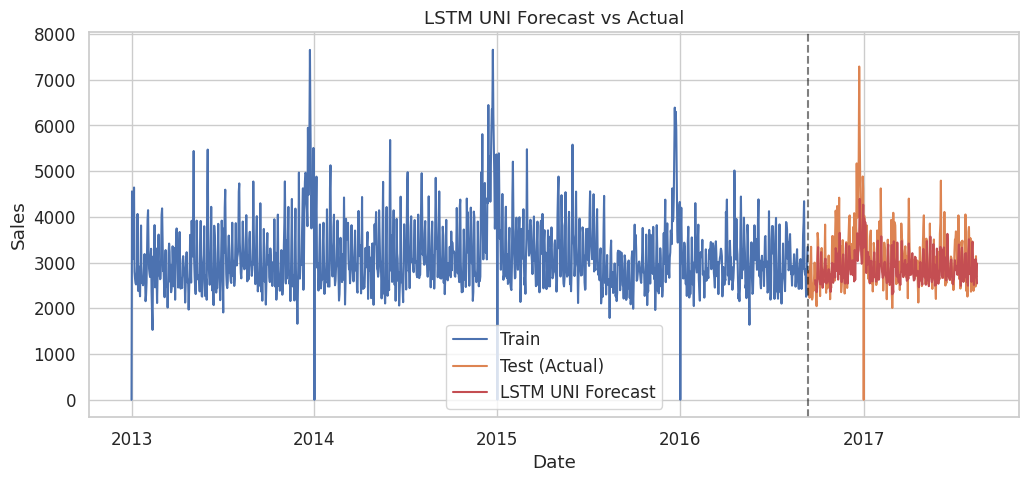

In [ ]:
# --- Buat index test yang sejajar (skip 14 langkah pertama test) ---
test_index_uni = test_sarima_uni.index[look_back:]

# --- Buat series hasil prediksi dan aktual (pakai flatten) ---
y_pred_series_uni = pd.Series(y_pred_test_rescaled.flatten(), index=test_index_uni)
y_test_series_uni = pd.Series(y_test_rescaled.flatten(), index=test_index_uni)

# --- Visualisasi ---
plt.figure(figsize=(12,5))

# Plot Train
plt.plot(train_sarima_uni.index, train_sarima_uni.values, label='Train')

# Plot Test (actual)
plt.plot(test_sarima_uni.index, test_sarima_uni.values, label='Test (Actual)')

# Plot Forecast
plt.plot(y_pred_series_uni.index, y_pred_series_uni.values, label='LSTM UNI Forecast', color='r')

# Garis pemisah train/test
plt.axvline(x=test_sarima_uni.index[0], color='black', linestyle='--', alpha=0.5)

plt.title('LSTM UNI Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
joblib.dump(model_lstm_uni, '/content/drive/MyDrive/Proyek/project1/model/lstm_uni_model.pkl')
print("Model LSTM tersimpan sebagai lstm_uni_model.pkl")

Model LSTM tersimpan sebagai lstm_uni_model.pkl


###### LSTM Multivariate Basic FE

In [ ]:
target = 'sales'
features = [col for col in grocery_basic.columns if col != target]

train_multi = grocery_basic[features].iloc[:train_size]
test_multi  = grocery_basic[features].iloc[train_size:]

X_train_multi = train_multi.values
X_test_multi  = test_multi.values

y_train_multi = grocery_basic[target].iloc[:train_size].values.reshape(-1,1)
y_test_multi  = grocery_basic[target].iloc[train_size:].values.reshape(-1,1)

# Log transform target
y_train_log = np.log1p(y_train_multi)
y_test_log  = np.log1p(y_test_multi)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# ---------------------------
# Scaling -1 to 1 for tanh
# ---------------------------
scaler_X = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler_X.fit_transform(X_train_multi)
X_test_scaled  = scaler_X.transform(X_test_multi)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled  = scaler_y.transform(y_test_log)


In [ ]:
look_back = 14

def create_multivariate_dataset(X, y, look_back=14):
    Xs, ys = [], []
    for i in range(len(X)-look_back):
        Xs.append(X[i:i+look_back, :])   # semua fitur
        ys.append(y[i+look_back, 0])     # target sales
    return np.array(Xs), np.array(ys)

X_train_multi_window, y_train_multi_window = create_multivariate_dataset(X_train_scaled, y_train_scaled, look_back)
X_test_multi_window, y_test_multi_window   = create_multivariate_dataset(X_test_scaled, y_test_scaled, look_back)

print("X_train:", X_train_multi_window.shape)
print("y_train:", y_train_multi_window.shape)

X_train: (1333, 14, 12)
y_train: (1333,)


In [ ]:
def objective_multi(trial):
    n_units = trial.suggest_int('n_units', 32, 256, log=True)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)

    model = Sequential()
    model.add(LSTM(n_units, activation='tanh', input_shape=(look_back, X_train_multi_window.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mae')

    model.fit(
        X_train_multi_window, y_train_multi_window,
        validation_split=0.2,
        epochs=50,
        batch_size=batch_size,
        verbose=1
    )

    # Predict test set
    y_pred = model.predict(X_test_multi_window, verbose=0)

    # Inverse transform (log space)
    y_pred_rescaled = np.expm1(scaler_y.inverse_transform(y_pred))
    y_test_rescaled = np.expm1(scaler_y.inverse_transform(y_test_multi_window.reshape(-1,1)))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    return rmse

# ---------------------------
# Run Optuna
# ---------------------------
study_multi = optuna.create_study(direction='minimize')
study_multi.optimize(objective_multi, n_trials=20)

print("Best hyperparameters:", study_multi.best_params)
print("Best RMSE:", study_multi.best_value)


[I 2025-10-13 06:52:51,471] A new study created in memory with name: no-name-8e96e952-b453-4a36-a1e2-6c36cc7d3737


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.2437 - val_loss: 0.0861
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.1143 - val_loss: 0.1384
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0947 - val_loss: 0.1377
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0866 - val_loss: 0.0775
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0783 - val_loss: 0.0930
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0745 - val_loss: 0.1092
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0674 - val_loss: 0.0965
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0626 - val_loss: 0.0682
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0656 - val_loss: 0.1107
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0666 - val_loss: 0.1216
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0708 - val_loss: 0.0890
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0634 - val_l

[I 2025-10-13 06:53:53,919] Trial 0 finished with value: 846.719199180134 and parameters: {'n_units': 134, 'lr': 0.0007132450322028872, 'batch_size': 32, 'dropout': 0.3517680507902975}. Best is trial 0 with value: 846.719199180134.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2408 - val_loss: 0.0598
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0841 - val_loss: 0.0694
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0766 - val_loss: 0.1037
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0671 - val_loss: 0.0627
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0601 - val_loss: 0.0956
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0581 - val_loss: 0.0697
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0600 - val_loss: 0.0536
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0543 - val_loss: 0.0494
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0536 - val_loss: 0.0419
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0516 - val_loss: 0.0359
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0558 - val_loss: 0.0376
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0548 - val_l

[I 2025-10-13 06:55:00,149] Trial 1 finished with value: 742.2097823034713 and parameters: {'n_units': 129, 'lr': 0.0012493041694601127, 'batch_size': 16, 'dropout': 0.29004633939786306}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.7669 - val_loss: 0.6900
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6264 - val_loss: 0.5903
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4856 - val_loss: 0.4883
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3510 - val_loss: 0.3824
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2161 - val_loss: 0.2683
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1650 - val_loss: 0.1674
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1458 - val_loss: 0.1258
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1389 - val_loss: 0.1188
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1245 - val_loss: 0.1157
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1207 - val_loss: 0.1081
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1150 - val_loss: 0.1033
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1132 - val_loss: 0.1044
Epoch 13/50


[I 2025-10-13 06:55:20,032] Trial 2 finished with value: 1642.9162117643118 and parameters: {'n_units': 61, 'lr': 0.00013512680590282958, 'batch_size': 128, 'dropout': 0.1502156681921196}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.6400 - val_loss: 0.5119
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.3700 - val_loss: 0.3531
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2115 - val_loss: 0.2540
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2284 - val_loss: 0.2591
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2094 - val_loss: 0.2824
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1976 - val_loss: 0.2611
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1900 - val_loss: 0.2415
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1841 - val_loss: 0.2350
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1804 - val_loss: 0.2548
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1648 - val_loss: 0.2303
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1691 - val_loss: 0.2091
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1603 - val_loss: 0.1983
Epoch 13/50

[I 2025-10-13 06:55:41,385] Trial 3 finished with value: 2109.226865973644 and parameters: {'n_units': 75, 'lr': 0.0002336382649879906, 'batch_size': 128, 'dropout': 0.4686726332248121}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.3847 - val_loss: 0.0875
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1110 - val_loss: 0.1008
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0918 - val_loss: 0.0650
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0838 - val_loss: 0.0604
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0766 - val_loss: 0.0979
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0698 - val_loss: 0.0783
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0658 - val_loss: 0.0597
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0657 - val_loss: 0.0475
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0662 - val_loss: 0.0547
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0617 - val_loss: 0.0719
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0604 - val_loss: 0.0542
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0529 - val_l

[I 2025-10-13 06:56:12,656] Trial 4 finished with value: 742.9532835425122 and parameters: {'n_units': 100, 'lr': 0.005609397107527226, 'batch_size': 64, 'dropout': 0.42908753409550104}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6951 - val_loss: 0.3147
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3076 - val_loss: 0.1459
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2568 - val_loss: 0.1367
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2362 - val_loss: 0.1204
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2239 - val_loss: 0.1098
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2039 - val_loss: 0.0956
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1914 - val_loss: 0.1057
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1828 - val_loss: 0.0880
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1698 - val_loss: 0.0818
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1707 - val_loss: 0.0892
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1561 - val_loss: 0.0856
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1518 - val_l

[I 2025-10-13 06:56:41,233] Trial 5 finished with value: 1387.91089664739 and parameters: {'n_units': 54, 'lr': 0.00016580572570392202, 'batch_size': 32, 'dropout': 0.4649393493265066}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.2302 - val_loss: 0.0925
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0592 - val_loss: 0.0814
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0617 - val_loss: 0.0678
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0534 - val_loss: 0.0822
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0464 - val_loss: 0.0505
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0468 - val_loss: 0.0589
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0464 - val_loss: 0.0650
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0442 - val_loss: 0.0541
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0422 - val_loss: 0.0686
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0453 - val_loss: 0.0783
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0402 - val_loss: 0.0831
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0378 - val_l

[I 2025-10-13 06:58:23,410] Trial 6 finished with value: 790.3941746645091 and parameters: {'n_units': 186, 'lr': 0.00046856594891588266, 'batch_size': 16, 'dropout': 0.1024776086386618}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1851 - val_loss: 0.1065
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0621 - val_loss: 0.0964
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0508 - val_loss: 0.1134
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0498 - val_loss: 0.0863
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0480 - val_loss: 0.0465
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0454 - val_loss: 0.0522
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0432 - val_loss: 0.0599
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0436 - val_loss: 0.0438
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0405 - val_loss: 0.0412
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0404 - val_loss: 0.0369
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0408 - val_loss: 0.0436
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0388 - val_l

[I 2025-10-13 06:59:21,890] Trial 7 finished with value: 988.4904137907379 and parameters: {'n_units': 105, 'lr': 0.003701780114808613, 'batch_size': 16, 'dropout': 0.11762835170085283}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.3776 - val_loss: 0.3479
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2059 - val_loss: 0.2473
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1814 - val_loss: 0.2438
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1710 - val_loss: 0.2141
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1585 - val_loss: 0.2206
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1556 - val_loss: 0.2111
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1607 - val_loss: 0.2142
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1482 - val_loss: 0.2012
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1484 - val_loss: 0.2166
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1331 - val_loss: 0.1774
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1397 - val_loss: 0.2036
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1353 - val_l

[I 2025-10-13 06:59:50,269] Trial 8 finished with value: 2034.5775887904103 and parameters: {'n_units': 58, 'lr': 0.0001354030251626406, 'batch_size': 32, 'dropout': 0.3271710994598308}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.3966 - val_loss: 0.0860
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0654 - val_loss: 0.1360
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0531 - val_loss: 0.1229
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0504 - val_loss: 0.1012
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0470 - val_loss: 0.1029
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0437 - val_loss: 0.0815
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0407 - val_loss: 0.0707
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0437 - val_loss: 0.0683
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0381 - val_loss: 0.0734
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0384 - val_loss: 0.0688
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0411 - val_loss: 0.0547
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0379 - val_l

[I 2025-10-13 07:00:49,567] Trial 9 finished with value: 751.5331181788237 and parameters: {'n_units': 204, 'lr': 0.00458924146968133, 'batch_size': 64, 'dropout': 0.1041374349000376}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2058 - val_loss: 0.1652
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0968 - val_loss: 0.1067
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0772 - val_loss: 0.1513
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0731 - val_loss: 0.0934
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0701 - val_loss: 0.1209
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0650 - val_loss: 0.0559
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0647 - val_loss: 0.0660
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0640 - val_loss: 0.0490
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0580 - val_loss: 0.0553
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0561 - val_loss: 0.0493
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0537 - val_loss: 0.0442
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0551 - val_loss: 

[I 2025-10-13 07:01:32,624] Trial 10 finished with value: 745.6777337366871 and parameters: {'n_units': 40, 'lr': 0.00195280604636928, 'batch_size': 16, 'dropout': 0.226465550516475}. Best is trial 1 with value: 742.2097823034713.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.5117 - val_loss: 0.0569
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1019 - val_loss: 0.1021
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0807 - val_loss: 0.0431
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0669 - val_loss: 0.0657
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0610 - val_loss: 0.0419
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0560 - val_loss: 0.0433
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0577 - val_loss: 0.0828
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0540 - val_loss: 0.0455
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0543 - val_loss: 0.0464
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0511 - val_loss: 0.0438
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0487 - val_loss: 0.0479
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0510 - val_l

[I 2025-10-13 07:02:06,080] Trial 11 finished with value: 709.3510662972604 and parameters: {'n_units': 130, 'lr': 0.009471259255228346, 'batch_size': 64, 'dropout': 0.3941594215941376}. Best is trial 11 with value: 709.3510662972604.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.4651 - val_loss: 0.0814
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0830 - val_loss: 0.0693
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0693 - val_loss: 0.0812
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0600 - val_loss: 0.0453
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0506 - val_loss: 0.0559
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0545 - val_loss: 0.0462
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0504 - val_loss: 0.0453
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0478 - val_loss: 0.0427
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0447 - val_loss: 0.0386
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0499 - val_loss: 0.0703
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0441 - val_loss: 0.0472
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0465 - val_l

[I 2025-10-13 07:02:44,245] Trial 12 finished with value: 708.6498636020295 and parameters: {'n_units': 142, 'lr': 0.008825681457292128, 'batch_size': 64, 'dropout': 0.25859822498600815}. Best is trial 12 with value: 708.6498636020295.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.7627 - val_loss: 0.1442
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0974 - val_loss: 0.0591
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0678 - val_loss: 0.0490
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0576 - val_loss: 0.0473
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0555 - val_loss: 0.0417
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0516 - val_loss: 0.0559
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0487 - val_loss: 0.0374
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0516 - val_loss: 0.0611
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0488 - val_loss: 0.0507
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0462 - val_loss: 0.0399
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0474 - val_loss: 0.0445
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0443 - val_

[I 2025-10-13 07:03:56,077] Trial 13 finished with value: 792.1918913570396 and parameters: {'n_units': 253, 'lr': 0.00987066503545543, 'batch_size': 64, 'dropout': 0.38748243528440784}. Best is trial 12 with value: 708.6498636020295.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.6038 - val_loss: 0.1641
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0856 - val_loss: 0.0783
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0576 - val_loss: 0.1129
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0561 - val_loss: 0.0825
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0550 - val_loss: 0.0514
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0493 - val_loss: 0.0500
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0460 - val_loss: 0.0862
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0454 - val_loss: 0.0475
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0429 - val_loss: 0.0546
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0458 - val_loss: 0.0444
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0440 - val_loss: 0.0454
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0460 - val_l

[I 2025-10-13 07:04:39,961] Trial 14 finished with value: 776.0751647072154 and parameters: {'n_units': 162, 'lr': 0.009636647574836291, 'batch_size': 64, 'dropout': 0.2581788693746983}. Best is trial 12 with value: 708.6498636020295.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.3717 - val_loss: 0.1165
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1031 - val_loss: 0.1521
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0747 - val_loss: 0.1078
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0670 - val_loss: 0.1099
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0644 - val_loss: 0.1324
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0587 - val_loss: 0.1238
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0535 - val_loss: 0.0753
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0547 - val_loss: 0.0546
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0554 - val_loss: 0.0757
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0525 - val_loss: 0.0771
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0538 - val_loss: 0.0899
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0493 - val_l

[I 2025-10-13 07:05:16,132] Trial 15 finished with value: 787.5838925200849 and parameters: {'n_units': 130, 'lr': 0.002405799933412342, 'batch_size': 64, 'dropout': 0.22563010159734104}. Best is trial 12 with value: 708.6498636020295.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.3479 - val_loss: 0.0858
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1011 - val_loss: 0.1016
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0812 - val_loss: 0.1225
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0769 - val_loss: 0.0550
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0721 - val_loss: 0.0542
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0703 - val_loss: 0.0785
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0658 - val_loss: 0.0811
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0727 - val_loss: 0.0692
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0572 - val_loss: 0.0517
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0625 - val_loss: 0.0621
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0560 - val_loss: 0.0400
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0520 - val_l

[I 2025-10-13 07:05:45,810] Trial 16 finished with value: 572.7200513790755 and parameters: {'n_units': 80, 'lr': 0.006324818293406337, 'batch_size': 64, 'dropout': 0.37939853518322103}. Best is trial 16 with value: 572.7200513790755.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.3439 - val_loss: 0.0688
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0935 - val_loss: 0.1884
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0816 - val_loss: 0.0825
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0655 - val_loss: 0.1028
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0617 - val_loss: 0.0793
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0599 - val_loss: 0.1107
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0587 - val_loss: 0.0689
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0548 - val_loss: 0.0620
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0574 - val_loss: 0.0597
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0505 - val_loss: 0.0683
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0552 - val_loss: 0.0631
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0526 - val_l

[I 2025-10-13 07:06:13,151] Trial 17 finished with value: 879.8616288913245 and parameters: {'n_units': 84, 'lr': 0.0028043247833609377, 'batch_size': 64, 'dropout': 0.16887582101225077}. Best is trial 16 with value: 572.7200513790755.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3142 - val_loss: 0.0632
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1244 - val_loss: 0.1407
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1022 - val_loss: 0.0937
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0826 - val_loss: 0.0610
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0799 - val_loss: 0.0604
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0765 - val_loss: 0.0515
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0718 - val_loss: 0.0491
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0696 - val_loss: 0.0601
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0654 - val_loss: 0.0509
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0627 - val_loss: 0.0442
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0615 - val_loss: 0.0435
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0562 - val_l

[I 2025-10-13 07:06:31,561] Trial 18 finished with value: 770.5696385432929 and parameters: {'n_units': 39, 'lr': 0.0061129952938350765, 'batch_size': 64, 'dropout': 0.2997076394069979}. Best is trial 16 with value: 572.7200513790755.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.5497 - val_loss: 0.1194
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1988 - val_loss: 0.2278
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1657 - val_loss: 0.1073
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1295 - val_loss: 0.1450
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.1256 - val_loss: 0.1247
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1109 - val_loss: 0.1376
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1064 - val_loss: 0.1252
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0942 - val_loss: 0.0989
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0940 - val_loss: 0.1435
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0893 - val_loss: 0.1014
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0878 - val_loss: 0.0975
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0827 - val_loss: 0.0873
Epoch 13/50

[I 2025-10-13 07:06:56,931] Trial 19 finished with value: 1244.5311592163107 and parameters: {'n_units': 71, 'lr': 0.0014407122107832676, 'batch_size': 128, 'dropout': 0.3587770533678231}. Best is trial 16 with value: 572.7200513790755.


Best hyperparameters: {'n_units': 80, 'lr': 0.006324818293406337, 'batch_size': 64, 'dropout': 0.37939853518322103}
Best RMSE: 572.7200513790755


In [ ]:
best_params = study_multi.best_params

# ---------------------------
# Train final model
# ---------------------------
model_lstm_multi_final = Sequential()
model_lstm_multi_final.add(LSTM(best_params['n_units'], activation='tanh', input_shape=(look_back, X_train_multi_window.shape[2])))
model_lstm_multi_final.add(Dropout(best_params['dropout']))
model_lstm_multi_final.add(Dense(1))
model_lstm_multi_final.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mae')

history_multi_final = model_lstm_multi_final.fit(
    X_train_multi_window, y_train_multi_window,
    validation_split=0.2,
    epochs=50,
    batch_size=best_params['batch_size'],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2931 - val_loss: 0.1813
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1326 - val_loss: 0.0818
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0965 - val_loss: 0.0897
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0791 - val_loss: 0.0968
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0764 - val_loss: 0.1078
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0717 - val_loss: 0.0722
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0675 - val_loss: 0.0605
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0737 - val_loss: 0.0440
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0659 - val_loss: 0.0461
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0622 - val_loss: 0.0658
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0599 - val_loss: 0.0476
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0530 - val_l

In [ ]:
# ---------------------------
# Evaluation
# ---------------------------
y_pred_multi = model_lstm_multi_final.predict(X_test_multi_window)
y_pred_multi_scaled = scaler_y.inverse_transform(y_pred_multi)
y_test_multi_scaled = scaler_y.inverse_transform(y_test_multi_window.reshape(-1,1))

# Inverse log transform
y_pred_multi_rescaled = np.expm1(y_pred_multi_scaled)
y_test_multi_rescaled = np.expm1(y_test_multi_scaled)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


Evaluation

In [ ]:
mse = mean_squared_error(y_test_multi_rescaled, y_pred_multi_rescaled)
mae = mean_absolute_error(y_test_multi_rescaled, y_pred_multi_rescaled)
rmse = np.sqrt(mse)
def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    nonzero_mask = y_true != 0
    if not np.any(nonzero_mask):
        return np.nan
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mask = (y_true != 0) | (y_pred != 0)
    if not np.any(mask):
        return np.nan
    return 100 * np.mean(
        2 * np.abs(y_pred[mask] - y_true[mask]) / (np.abs(y_true[mask]) + np.abs(y_pred[mask]))
    )

mape = calculate_mape(y_test_multi_rescaled, y_pred_multi_rescaled)
smape = calculate_smape(y_test_multi_rescaled, y_pred_multi_rescaled)
r2 = r2_score(y_test_multi_rescaled, y_pred_multi_rescaled)

eval_table_lstm_multi_basic = pd.DataFrame({
    'Algorithm': ['LSTM MULTI BASIC (tanh)'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'SMAPE (%)': [smape],
    'R2': [r2]
})

display(eval_table_lstm_multi_basic.style.background_gradient(cmap='Blues', subset=['MAE','MSE','RMSE','MAPE (%)','SMAPE (%)','R2']))

Forecasting

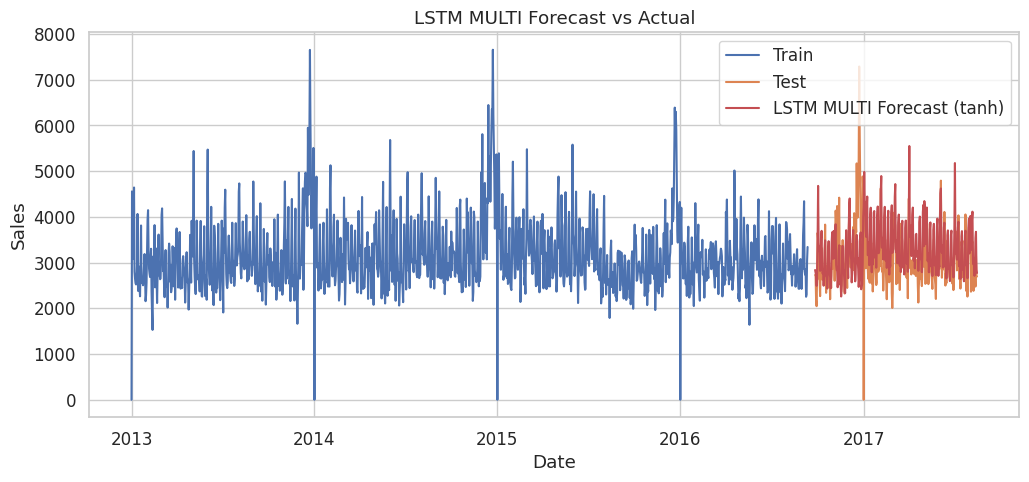

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

y_test_series = pd.Series(y_test_multi_rescaled.flatten(), index=test_basic.index[look_back:])
y_pred_series_multi = pd.Series(y_pred_multi_rescaled.flatten(), index=test_basic.index[look_back:])

plt.figure(figsize=(12,5))
plt.plot(train_basic['sales'], label='Train')
plt.plot(y_test_series, label='Test')
plt.plot(y_pred_series_multi, label='LSTM MULTI Forecast (tanh)', color='r')
plt.title('LSTM MULTI Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
joblib.dump(model_lstm_multi_final, '/content/drive/MyDrive/Proyek/project1/model/lstm_multi_basic_model.pkl')
print("Model LSTM tersimpan sebagai lstm_multi_basic_model.pkl")

Model LSTM tersimpan sebagai lstm_multi_basic_model.pkl


###### LSTM Multivariate Advance FE

In [ ]:
target = 'sales'
features = [col for col in df_grocery_adv.columns if col != target]

train_multi = df_grocery_adv[features].iloc[:train_size]
test_multi  = df_grocery_adv[features].iloc[train_size:]

X_train_multi = train_multi.values
X_test_multi  = test_multi.values

y_train_multi = df_grocery_adv[target].iloc[:train_size].values.reshape(-1,1)
y_test_multi  = df_grocery_adv[target].iloc[train_size:].values.reshape(-1,1)

# ---------------------------
# Log transform target
# ---------------------------
y_train_log = np.log1p(y_train_multi)
y_test_log  = np.log1p(y_test_multi)


In [ ]:
# ---------------------------
# Scaling -1 ~ 1 (for tanh)
# ---------------------------
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler_X.fit_transform(X_train_multi)
X_test_scaled  = scaler_X.transform(X_test_multi)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled  = scaler_y.transform(y_test_log)

print("X_test_scaled:", X_test_scaled.shape)
print("y_test_scaled:", y_test_scaled.shape)

X_test_scaled: (309, 10)
y_test_scaled: (309, 1)


In [ ]:
look_back = 14  # panjang window time step

def create_multivariate_dataset(X, y, look_back=14):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i+look_back, :])
        ys.append(y[i+look_back, 0])
    return np.array(Xs), np.array(ys)

X_train_multi_window, y_train_multi_window = create_multivariate_dataset(X_train_scaled, y_train_scaled, look_back)
X_test_multi_window, y_test_multi_window   = create_multivariate_dataset(X_test_scaled, y_test_scaled, look_back)

print("X_train:", X_train_multi_window.shape)
print("y_train:", y_train_multi_window.shape)

X_train: (1333, 14, 10)
y_train: (1333,)


In [ ]:
def objective_multi(trial):
    n_units = trial.suggest_int('n_units', 10, 100)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout_rate = trial.suggest_float('dropout', 0.0, 0.3)

    model = Sequential()
    model.add(LSTM(n_units, activation='tanh', input_shape=(look_back, X_train_multi_window.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mae')

    model.fit(
        X_train_multi_window, y_train_multi_window,
        validation_split=0.2,
        epochs=50,
        batch_size=batch_size,
        verbose=1
    )

    # Predict test
    y_pred = model.predict(X_test_multi_window, verbose=0)

    # Inverse transform
    y_pred_rescaled = np.expm1(scaler_y.inverse_transform(y_pred))
    y_test_rescaled = np.expm1(scaler_y.inverse_transform(y_test_multi_window.reshape(-1,1)))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    return rmse

# Jalankan tuning
study_multi = optuna.create_study(direction='minimize')
study_multi.optimize(objective_multi, n_trials=20)

print("Best hyperparameters:", study_multi.best_params)
print("Best RMSE:", study_multi.best_value)

[I 2025-10-13 07:13:52,382] A new study created in memory with name: no-name-69d0dc56-099e-4913-8491-5b676869c007


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.8526 - val_loss: 0.7580
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6898 - val_loss: 0.5720
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5101 - val_loss: 0.3671
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3101 - val_loss: 0.1503
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2000 - val_loss: 0.0532
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1920 - val_loss: 0.0593
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1874 - val_loss: 0.0603
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1837 - val_loss: 0.0560
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1708 - val_loss: 0.0523
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1736 - val_loss: 0.0516
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1734 - val_loss: 0.0455
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1537 - val_l

[I 2025-10-13 07:14:14,880] Trial 0 finished with value: 710.5183757073411 and parameters: {'n_units': 21, 'lr': 0.000265092371228113, 'batch_size': 64, 'dropout': 0.19393265431139933}. Best is trial 0 with value: 710.5183757073411.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.9149 - val_loss: 0.7706
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8255 - val_loss: 0.6647
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7181 - val_loss: 0.5560
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6144 - val_loss: 0.4423
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4958 - val_loss: 0.3230
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3745 - val_loss: 0.1995
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2671 - val_loss: 0.1135
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2005 - val_loss: 0.0980
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1819 - val_loss: 0.0917
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1666 - val_loss: 0.0839
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1691 - val_loss: 0.0741
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1549 - val_l

[I 2025-10-13 07:14:31,656] Trial 1 finished with value: 797.5564508716269 and parameters: {'n_units': 11, 'lr': 0.00020111572400455054, 'batch_size': 64, 'dropout': 0.05971581227172493}. Best is trial 0 with value: 710.5183757073411.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2941 - val_loss: 0.0302
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0698 - val_loss: 0.0307
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0541 - val_loss: 0.0289
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0463 - val_loss: 0.0299
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0494 - val_loss: 0.0263
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0491 - val_loss: 0.0270
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0466 - val_loss: 0.0278
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0429 - val_loss: 0.0468
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0458 - val_loss: 0.0270
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0415 - val_loss: 0.0273
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0418 - val_loss: 0.0261
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0410 - val_l

[I 2025-10-13 07:14:58,797] Trial 2 finished with value: 677.6349557727443 and parameters: {'n_units': 34, 'lr': 0.008446798171626432, 'batch_size': 32, 'dropout': 0.08033677824336487}. Best is trial 2 with value: 677.6349557727443.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3171 - val_loss: 0.0417
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1439 - val_loss: 0.0341
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1107 - val_loss: 0.0320
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0988 - val_loss: 0.0419
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0927 - val_loss: 0.0296
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0871 - val_loss: 0.0279
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0772 - val_loss: 0.0302
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0849 - val_loss: 0.0261
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0735 - val_loss: 0.0253
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0743 - val_loss: 0.0251
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0735 - val_loss: 0.0257
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0677 - val_l

[I 2025-10-13 07:15:23,786] Trial 3 finished with value: 647.3965095738324 and parameters: {'n_units': 38, 'lr': 0.0008860328510433539, 'batch_size': 32, 'dropout': 0.2090084458584575}. Best is trial 3 with value: 647.3965095738324.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2698 - val_loss: 0.0325
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0768 - val_loss: 0.0276
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0580 - val_loss: 0.0446
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0618 - val_loss: 0.0282
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0616 - val_loss: 0.0269
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0505 - val_loss: 0.0364
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0548 - val_loss: 0.0314
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0519 - val_loss: 0.0249
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0440 - val_loss: 0.0312
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0480 - val_loss: 0.0272
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0415 - val_loss: 0.0378
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0416 - val_l

[I 2025-10-13 07:15:50,487] Trial 4 finished with value: 652.0190153661764 and parameters: {'n_units': 49, 'lr': 0.005773578407530302, 'batch_size': 32, 'dropout': 0.13241692670453895}. Best is trial 3 with value: 647.3965095738324.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.6628 - val_loss: 0.5937
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5216 - val_loss: 0.4565
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3785 - val_loss: 0.3171
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2489 - val_loss: 0.2023
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2058 - val_loss: 0.1335
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1880 - val_loss: 0.1111
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1739 - val_loss: 0.1081
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1746 - val_loss: 0.1045
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1558 - val_loss: 0.0977
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1563 - val_loss: 0.0889
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1470 - val_loss: 0.0802
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1391 - val_l

[I 2025-10-13 07:16:07,739] Trial 5 finished with value: 852.8317661847195 and parameters: {'n_units': 10, 'lr': 0.0003254364508484752, 'batch_size': 64, 'dropout': 0.10691357763165212}. Best is trial 3 with value: 647.3965095738324.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.3125 - val_loss: 0.0589
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0744 - val_loss: 0.0309
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0385 - val_loss: 0.0297
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0387 - val_loss: 0.0259
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0348 - val_loss: 0.0271
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0307 - val_loss: 0.0332
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0348 - val_loss: 0.0261
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0349 - val_loss: 0.0252
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0347 - val_loss: 0.0253
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0312 - val_loss: 0.0245
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0319 - val_loss: 0.0308
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0371 - val_l

[I 2025-10-13 07:16:25,275] Trial 6 finished with value: 647.7308211543852 and parameters: {'n_units': 29, 'lr': 0.007285973750268392, 'batch_size': 64, 'dropout': 0.0036894204536252026}. Best is trial 3 with value: 647.3965095738324.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2127 - val_loss: 0.0537
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0638 - val_loss: 0.0584
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0548 - val_loss: 0.0319
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0503 - val_loss: 0.0252
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0540 - val_loss: 0.0280
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0419 - val_loss: 0.0293
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0473 - val_loss: 0.0307
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0454 - val_loss: 0.0306
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0424 - val_loss: 0.0253
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0441 - val_loss: 0.0273
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0390 - val_loss: 0.0258
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0393 - val_loss: 0

[I 2025-10-13 07:17:05,254] Trial 7 finished with value: 723.3201058675816 and parameters: {'n_units': 25, 'lr': 0.0037670433848935917, 'batch_size': 16, 'dropout': 0.056008436136817275}. Best is trial 3 with value: 647.3965095738324.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1505 - val_loss: 0.0273
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0419 - val_loss: 0.0296
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0387 - val_loss: 0.0261
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0338 - val_loss: 0.0247
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0362 - val_loss: 0.0251
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0302 - val_loss: 0.0277
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0325 - val_loss: 0.0278
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0300 - val_loss: 0.0280
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0342 - val_loss: 0.0297
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0277 - val_loss: 0.0270
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0290 - val_loss: 0.0255
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0286 - val_loss: 0.

[I 2025-10-13 07:17:46,477] Trial 8 finished with value: 704.311551749688 and parameters: {'n_units': 35, 'lr': 0.005215053646295492, 'batch_size': 16, 'dropout': 0.0030284488623077755}. Best is trial 3 with value: 647.3965095738324.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2370 - val_loss: 0.0460
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0550 - val_loss: 0.0285
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0407 - val_loss: 0.0276
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0435 - val_loss: 0.0341
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0541 - val_loss: 0.0264
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0361 - val_loss: 0.0361
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0464 - val_loss: 0.0329
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0380 - val_loss: 0.0278
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0383 - val_loss: 0.0245
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0373 - val_loss: 0.0376
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0354 - val_loss: 0.0255
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0380 - val_l

[I 2025-10-13 07:18:37,132] Trial 9 finished with value: 760.9945072726812 and parameters: {'n_units': 100, 'lr': 0.0008310764182221305, 'batch_size': 16, 'dropout': 0.024562925206697995}. Best is trial 3 with value: 647.3965095738324.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.3823 - val_loss: 0.0633
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1187 - val_loss: 0.0303
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0953 - val_loss: 0.0262
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0789 - val_loss: 0.0265
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0780 - val_loss: 0.0302
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0801 - val_loss: 0.0410
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0721 - val_loss: 0.0261
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0684 - val_loss: 0.0303
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0637 - val_loss: 0.0265
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0642 - val_loss: 0.0253
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0611 - val_loss: 0.0512
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0711 - val_l

[I 2025-10-13 07:19:09,985] Trial 10 finished with value: 642.9704211759849 and parameters: {'n_units': 66, 'lr': 0.0014877644611539004, 'batch_size': 32, 'dropout': 0.2827094380062627}. Best is trial 10 with value: 642.9704211759849.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.4671 - val_loss: 0.0523
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1137 - val_loss: 0.0403
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0887 - val_loss: 0.0314
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0824 - val_loss: 0.0287
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0773 - val_loss: 0.0344
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0738 - val_loss: 0.0386
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0745 - val_loss: 0.0268
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0657 - val_loss: 0.0305
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0626 - val_loss: 0.0311
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0637 - val_loss: 0.0252
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0619 - val_loss: 0.0329
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0619 - val_l

[I 2025-10-13 07:19:41,934] Trial 11 finished with value: 628.1687822118839 and parameters: {'n_units': 76, 'lr': 0.00138062002369634, 'batch_size': 32, 'dropout': 0.29186545969495953}. Best is trial 11 with value: 628.1687822118839.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.2594 - val_loss: 0.0558
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0934 - val_loss: 0.0304
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0831 - val_loss: 0.0329
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0768 - val_loss: 0.0295
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0728 - val_loss: 0.0407
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0637 - val_loss: 0.0270
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0599 - val_loss: 0.0291
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0605 - val_loss: 0.0263
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0651 - val_loss: 0.0306
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0584 - val_loss: 0.0298
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0596 - val_loss: 0.0249
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0571 - val_l

[I 2025-10-13 07:20:12,557] Trial 12 finished with value: 673.6118493765281 and parameters: {'n_units': 76, 'lr': 0.002000544787369723, 'batch_size': 32, 'dropout': 0.28839258132058304}. Best is trial 11 with value: 628.1687822118839.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.3544 - val_loss: 0.0438
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1025 - val_loss: 0.0627
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0774 - val_loss: 0.0264
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0730 - val_loss: 0.0384
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0690 - val_loss: 0.0520
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0737 - val_loss: 0.0330
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0651 - val_loss: 0.0286
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0650 - val_loss: 0.0270
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0662 - val_loss: 0.0264
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0617 - val_loss: 0.0268
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0530 - val_loss: 0.0514
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0570 - val_l

[I 2025-10-13 07:20:43,334] Trial 13 finished with value: 637.9567438624986 and parameters: {'n_units': 75, 'lr': 0.0019654495119286845, 'batch_size': 32, 'dropout': 0.2919715502805574}. Best is trial 11 with value: 628.1687822118839.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.4203 - val_loss: 0.0674
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1466 - val_loss: 0.0402
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1063 - val_loss: 0.0349
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0810 - val_loss: 0.0303
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0775 - val_loss: 0.0365
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0698 - val_loss: 0.0336
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0747 - val_loss: 0.0286
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0688 - val_loss: 0.0272
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0692 - val_loss: 0.0405
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0641 - val_loss: 0.0367
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0567 - val_loss: 0.0301
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0638 - val_l

[I 2025-10-13 07:21:18,294] Trial 14 finished with value: 647.242640293851 and parameters: {'n_units': 83, 'lr': 0.000493396120637599, 'batch_size': 32, 'dropout': 0.23467345893429054}. Best is trial 11 with value: 628.1687822118839.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3184 - val_loss: 0.0350
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0946 - val_loss: 0.0327
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0823 - val_loss: 0.0357
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0740 - val_loss: 0.0339
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0646 - val_loss: 0.0387
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0690 - val_loss: 0.0361
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0627 - val_loss: 0.0248
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0591 - val_loss: 0.0266
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0611 - val_loss: 0.0301
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0583 - val_loss: 0.0348
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0628 - val_loss: 0.0274
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0577 - val_l

[I 2025-10-13 07:21:47,565] Trial 15 finished with value: 618.3913142375276 and parameters: {'n_units': 62, 'lr': 0.002548108941720016, 'batch_size': 32, 'dropout': 0.24583728508526573}. Best is trial 15 with value: 618.3913142375276.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3242 - val_loss: 0.0551
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0946 - val_loss: 0.0316
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0691 - val_loss: 0.0370
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0715 - val_loss: 0.0257
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0719 - val_loss: 0.0633
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0727 - val_loss: 0.0328
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0549 - val_loss: 0.0284
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0578 - val_loss: 0.0300
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0587 - val_loss: 0.0324
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0603 - val_loss: 0.0294
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0537 - val_loss: 0.0247
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0518 - val_l

[I 2025-10-13 07:22:16,544] Trial 16 finished with value: 645.686784610821 and parameters: {'n_units': 55, 'lr': 0.0032877176668182576, 'batch_size': 32, 'dropout': 0.24469972087623104}. Best is trial 15 with value: 618.3913142375276.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.7165 - val_loss: 0.2054
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1963 - val_loss: 0.0515
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1531 - val_loss: 0.0469
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1364 - val_loss: 0.0434
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1111 - val_loss: 0.0449
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1106 - val_loss: 0.0414
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0906 - val_loss: 0.0378
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0765 - val_loss: 0.0405
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0796 - val_loss: 0.0346
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0760 - val_loss: 0.0326
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0701 - val_loss: 0.0305
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0722 - val_l

[I 2025-10-13 07:22:57,997] Trial 17 finished with value: 831.5262606342268 and parameters: {'n_units': 97, 'lr': 0.0001148775912316273, 'batch_size': 32, 'dropout': 0.1698835801936743}. Best is trial 15 with value: 618.3913142375276.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.5786 - val_loss: 0.0670
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1289 - val_loss: 0.0321
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0977 - val_loss: 0.0320
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0843 - val_loss: 0.0363
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0740 - val_loss: 0.0305
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0724 - val_loss: 0.0295
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0706 - val_loss: 0.0328
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0697 - val_loss: 0.0259
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0658 - val_loss: 0.0271
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0687 - val_loss: 0.0247
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0636 - val_loss: 0.0247
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0641 - val_l

[I 2025-10-13 07:23:28,522] Trial 18 finished with value: 671.8477941483252 and parameters: {'n_units': 64, 'lr': 0.0005964540888977185, 'batch_size': 32, 'dropout': 0.251486390321421}. Best is trial 15 with value: 618.3913142375276.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.2995 - val_loss: 0.0394
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0799 - val_loss: 0.0572
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0677 - val_loss: 0.0294
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0710 - val_loss: 0.0267
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0633 - val_loss: 0.0337
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0634 - val_loss: 0.0443
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0593 - val_loss: 0.0357
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0575 - val_loss: 0.0342
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0608 - val_loss: 0.0453
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0584 - val_loss: 0.0308
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0592 - val_loss: 0.0348
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0497 - val_l

[I 2025-10-13 07:24:23,264] Trial 19 finished with value: 625.4481785598716 and parameters: {'n_units': 88, 'lr': 0.0013775753257972438, 'batch_size': 16, 'dropout': 0.26045904502186656}. Best is trial 15 with value: 618.3913142375276.


Best hyperparameters: {'n_units': 62, 'lr': 0.002548108941720016, 'batch_size': 32, 'dropout': 0.24583728508526573}
Best RMSE: 618.3913142375276


In [ ]:
best_params = study_multi.best_params

# ==========================================
# 🏁 Train Final Model
# ==========================================
model_lstm_multi_final = Sequential()
model_lstm_multi_final.add(LSTM(best_params['n_units'], activation='tanh', input_shape=(look_back, X_train_multi_window.shape[2])))
model_lstm_multi_final.add(Dropout(best_params['dropout']))
model_lstm_multi_final.add(Dense(1))
model_lstm_multi_final.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mae')

history_multi_final = model_lstm_multi_final.fit(
    X_train_multi_window, y_train_multi_window,
    validation_split=0.2,
    epochs=50,
    batch_size=best_params['batch_size'],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2819 - val_loss: 0.0399
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0869 - val_loss: 0.0293
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0804 - val_loss: 0.0267
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0713 - val_loss: 0.0328
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0686 - val_loss: 0.0253
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0628 - val_loss: 0.0472
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0674 - val_loss: 0.0537
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0637 - val_loss: 0.0265
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0636 - val_loss: 0.0253
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0521 - val_loss: 0.0261
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0513 - val_loss: 0.0262
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0546 - val_l

In [ ]:
y_pred_multi = model_lstm_multi_final.predict(X_test_multi_window)
y_pred_multi_scaled = scaler_y.inverse_transform(y_pred_multi)
y_test_multi_scaled = scaler_y.inverse_transform(y_test_multi_window.reshape(-1,1))

# Undo log transform
y_pred_multi_rescaled = np.expm1(y_pred_multi_scaled)
y_test_multi_rescaled = np.expm1(y_test_multi_scaled)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_multi_rescaled, y_pred_multi_rescaled)
mae = mean_absolute_error(y_test_multi_rescaled, y_pred_multi_rescaled)
rmse = np.sqrt(mse)
def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    nonzero_mask = y_true != 0
    if not np.any(nonzero_mask):
        return np.nan
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mask = (y_true != 0) | (y_pred != 0)
    if not np.any(mask):
        return np.nan
    return 100 * np.mean(
        2 * np.abs(y_pred[mask] - y_true[mask]) / (np.abs(y_true[mask]) + np.abs(y_pred[mask]))
    )

mape = calculate_mape(y_test_multi_rescaled, y_pred_multi_rescaled)
smape = calculate_smape(y_test_multi_rescaled, y_pred_multi_rescaled)

r2 = r2_score(y_test_multi_rescaled, y_pred_multi_rescaled)

eval_table_lstm_multi_adv = pd.DataFrame({
    'Algorithm': ['LSTM MULTI ADV (tanh)'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'SMAPE (%)': [smape],
    'R2': [r2]
})

# Tampilkan hasil evaluasi
display(eval_table_lstm_multi_adv.style.background_gradient(
    cmap='Blues',
    subset=['MAE','MSE','RMSE','MAPE (%)','SMAPE (%)','R2']
))


Forecasting

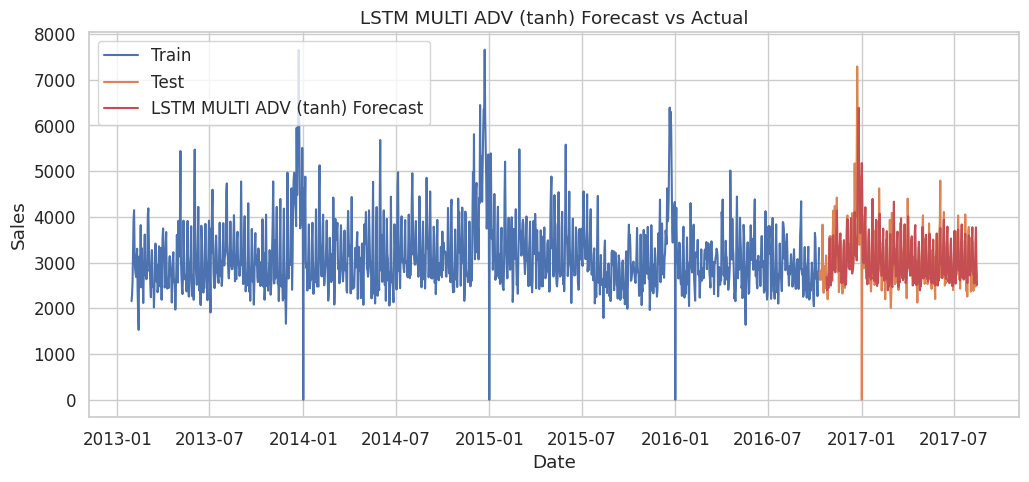

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

test_index_adv = df_grocery_adv.iloc[train_size:].index[look_back:]
y_pred_series_multi = pd.Series(y_pred_multi_rescaled.flatten(), index=test_index_adv)

plt.figure(figsize=(12,5))
plt.plot(df_grocery_adv.iloc[:train_size]['sales'], label='Train')
plt.plot(df_grocery_adv.iloc[train_size:]['sales'], label='Test')
plt.plot(y_pred_series_multi, label='LSTM MULTI ADV (tanh) Forecast', color='r')
plt.title('LSTM MULTI ADV (tanh) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
joblib.dump(model_lstm_multi_final, '/content/drive/MyDrive/Proyek/project1/model/lstm_multi_adv_model.pkl')
print("Model LSTM tersimpan sebagai lstm_multi_adv_model.pkl")

Model LSTM tersimpan sebagai lstm_multi_adv_model.pkl


## Comparison Model

In [ ]:
eval_all = pd.concat([
    eval_table_sarima,
    eval_table_sarimax_basic_fe,
    eval_table_sarimax_adv_fe,
    eval_table_lstm_uni,
    eval_table_lstm_multi_basic,
    eval_table_lstm_multi_adv
], ignore_index=True)

# Cek hasil
eval_all

Algorithm         MAE            MSE        RMSE   MAPE (%)  \
0                   SARIMA  465.848023  464184.155279  681.310616  13.805729   
1         SARIMAX BASIC FE  373.479085  318089.570122  563.994300  11.608827   
2           SARIMAX ADV FE  358.134833  312298.398795  558.836648  10.746205   
3                 LSTM UNI  383.248079  330288.030411  574.706908  11.084993   
4  LSTM MULTI BASIC (tanh)  485.206869  486671.593649  697.618516  15.061465   
5    LSTM MULTI ADV (tanh)  383.665858  386761.483611  621.901506  11.104266   

   SMAPE (%)        R2  
0  15.146622 -0.156900  
1  12.260136  0.207216  
2  11.511708  0.236775  
3  12.334606  0.184520  
4  14.912794 -0.201590  
5  11.894976  0.075248

## Forecasting Best Model

Best Model SARIMAX dengan Advanced Features

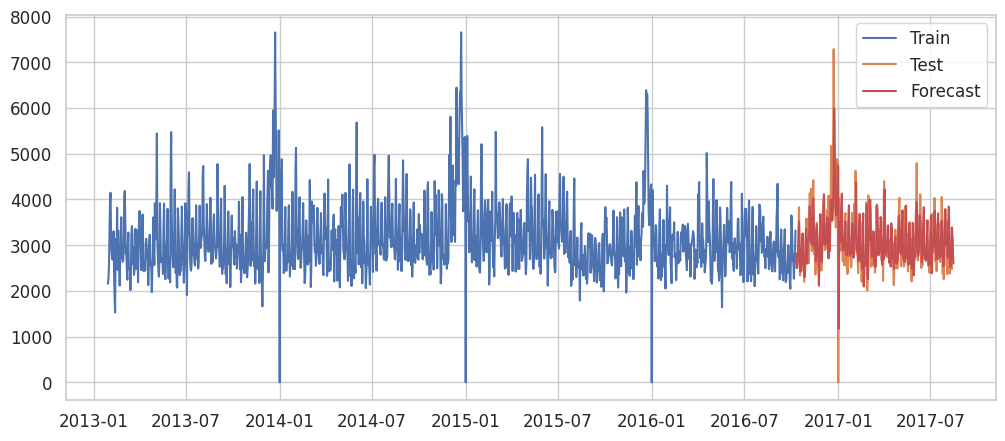

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train_endog_adv, label='Train')
plt.plot(test_endog_adv, label='Test')
plt.plot(forecast_sarimax_adv, label='Forecast', color='r')
plt.legend()
plt.show()
